In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")

pd.options.display.max_columns = None

import sys

sys.path.append("..")
from sgs_utils.path_conf import loc_data_dir
from scipy.stats import mannwhitneyu, kstest, wilcoxon


# Speech feature visualization - **fixed duration**

In [3]:
DUR_S = 15

In [4]:
# load the required data
df_feat_tot = pd.read_parquet(
    loc_data_dir.joinpath(f"df_speech_feat_tot_{DUR_S}s.parquet")
)
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot.parquet"))
df_metric = pd.read_parquet(loc_data_dir.joinpath("df_metric.parquet"))

# and merge the data 
df_session_m = pd.merge(df_session, df_metric, on=["ID", "DB", "time_str"], how="left")
df_session_feat = df_session.merge(
    df_feat_tot, on=["ID", "DB", "pic_name", "time_str"], how="left"
)

# add a speech_style column to df_session_feat
df_session_feat["speech_style"] = df_session_feat.DB.map(
    lambda x: {"marloes": "Read", "PiSCES": "SGS", "Radboud": "SGS"}.get(x)
)

df_session_feat.head(3)


age education   sex                        timestamp  \
0   26        so  male 2020-11-26 09:48:19.292420+01:00   
1   26        so  male 2020-11-26 09:48:19.292420+01:00   
2   26        so  male 2020-11-26 09:48:19.292420+01:00   

                                     ID  Marloes  PiSCES  Radboud device  \
0  a97a84b6-7a66-461f-810e-b54bac686f64        7      15       15    NaN   
1  a97a84b6-7a66-461f-810e-b54bac686f64        7      15       15    NaN   
2  a97a84b6-7a66-461f-810e-b54bac686f64        7      15       15    NaN   

  prolific_token pic_name  time_str  wav_size  wav_sample_rate  \
0           None  marloes  09:54:08   1892396            44100   
1           None  marloes  09:56:34    139308            44100   
2           None  marloes  09:57:31    106540            44100   

   wav_duration_s             wav_timestamp       DB  arousal  valence  DB_no  \
0           21.46 2020-11-26 09:54:08+01:00  marloes      0.0     10.0      1   
1            1.58 2020-11-26 09:56:34+01:00  marloes     76.0     65.0      2   
2            1.21 2020-11-26 09:57:30+01:00  marloes     97.0     67.0      3   

   session_no  pic_no  pic_count  \
0           1     NaN        NaN   
1           7     NaN        NaN   
2          13     NaN        NaN   

                                                file  start  \
0  /media/speech_webapp_merged/backup/2020-11-26_... 0 days   
1  /media/speech_webapp_merged/backup/2020-11-26_... 0 days   
2  /media/speech_webapp_merged/backup/2020-11-26_... 0 days   

                          end  F0semitoneFrom27.5Hz_sma3nz_amean  \
0   0 days 00:00:09.727619048                          25.631042   
1 -1 days +23:59:59.789478458                          32.009979   
2 -1 days +23:59:59.603718821                          26.517757   

   F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                0.381289   
1                                0.425717   
2                                0.252797   

   F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                   21.436550   
1                                   23.448944   
2                                   24.547390   

   F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                   23.495531   
1                                   25.953222   
2                                   25.928925   

   F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                   25.492611   
1                                   34.750538   
2                                   28.271545   

   F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                  4.056061   
1                                 11.301594   
2                                  3.724155   

   F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                   567.210510   
1                                   122.017433   
2                                    86.683334   

   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
0                                     818.694824   
1                                      11.140298   
2                                      46.188461   

   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope  \
0                                    215.160538   
1                                     65.508141   
2                                    164.639038   

   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  loudness_sma3_amean  \
0                                      196.989822             0.182427   
1                                       29.196917             0.559272   
2                                      192.596680             0.501420   

   loudness_sma3_stddevNorm  loudness_sma3_percentile20.0  \
0                  0.808861                      0.049991   
1                  0.620317                      0.260973   
2                  0.777349                      0.191968   

   loudness_sma3_percentile50.0  loudness_sma3_percentile80.0  \
0                

## Participant filtering

In [5]:
ids_to_skip = [
    "a97a84b6-7a66-461f-810e-b54bac686f64",  # Test run mitchel (a lot of short sessions)
    "a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f",  # Too much short sessions
    "87eafb16-0598-4340-9564-8e630acf85d6",  # This prolific users does not want to be included into the data analysis
    # TODO -> we do not need to throw thes all away; but for sake of simplicity we do now
    # "716dc108-5588-49ed-bf3c-04fb87212e2b",  # Got Picture 59 twice
    # "9223720f-1a2a-4811-84a1-a421646f63a0",  # Got Picture 59 twice
    # "e0c00b33-2151-4bcf-98b8-82f7701fccea",  # Got Picture 81 and Rafd090_32_Caucasian_female_neutral_frontal twice
]


In [6]:
valid_mask = (
    (df_session_feat.wav_duration_s > DUR_S + 1.5)
    & (df_session_feat.wav_size > 400)
    & (~df_session_feat.ID.isin(ids_to_skip))
    & ~(
        (df_session_m.filter(like="mosnet").mean(axis=1) < 2)
        | (df_session_m.filter(like="mosnet").min(axis=1) < 1.5)
        | (df_session_m.filter(like="srmr").median(axis=1) < 0.5)
    )
)

print(df_session_feat.shape)
df_session_feat[valid_mask].shape


(3327, 125)


(3123, 125)

In [7]:
# df_session_feat[(df_session_feat.wav_duration_s < DUR_S + 2) & (df_session_feat.DB != 'marloes')].groupby(by=['ID', 'DB']).size().to_frame()

# Visualizations

In [8]:
# non speech feature variables
id_vars = [
    "file",
    "start",
    "end",
    "DB",
    "speech_style",
    "DB_no",
    "education",
    "timestamp",
    "time_str",
    "sex",
    "age",
    "PiSCES",
    "Radboud",
    "session_no",
    "ID",
    "wav_size",
    "device",
    "pic_name",
    "arousal",
    "valence",
    "pic_no",
    "prolific_token",
    "pic_count",
    "wav_timestamp",
    "wav_sample_rate",
    "Marloes",
]


## Statistics

We first test for normality using the kolmogorov smirnov test

In [9]:
for c in ["speech_style", "DB"]:
    for option in df_session_feat[c].unique():
        for feature in set(df_session_feat.columns).difference(list(id_vars)):
            pval = kstest(
                df_session_feat[valid_mask & (df_session_feat[c] == option)][
                    feature
                ].dropna(),
                "norm",
                alternative="two_sided",
            ).pvalue
            if pval > 0.000001:
                print(
                    f"{c:<20s}\t{option:<20s}\t{feature:<20s}\t{pval}{round(pval, 4)}"
                )
    print("---" * 20)

del c, pval, option, feature

------------------------------------------------------------
------------------------------------------------------------


The null hypothesis was rejected each time, **All features have a non normal distriubtion**; so we need to use non-parametric tests in all future statistics

### `speech_style`: *read* vs *SGS* speech

In [10]:
# First we calculate the statistics on both the read (=marloes) and the SGS (= PiSCES + Radboud)
feat_score_list = []
for feature in set(df_session_feat.columns).difference(list(id_vars)):
    test = mannwhitneyu(
        df_session_feat[(df_session_feat.speech_style == "Read") & valid_mask][feature],
        df_session_feat[(df_session_feat.speech_style == "SGS") & valid_mask][feature],
        alternative="two-sided",
        nan_policy="omit",
    )
    feat_score_list.append([feature, test.pvalue])

df_ss = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_ss_rel = df_ss[df_ss.p_value < 0.001]
df_ss_rel_05 = df_ss[df_ss.p_value < 0.05]

del feat_score_list, test, df_ss, feature


### `Database`: *pisces* vs *radboud*

In [11]:
feat_score_list = []
for feature in set(df_session_feat.columns).difference(list(id_vars)):
    # print(feature)
    test = mannwhitneyu(
        df_session_feat[(df_session_feat.DB == "PiSCES") & valid_mask][feature],
        df_session_feat[(df_session_feat.DB == "Radboud") & valid_mask][feature],
        alternative="two-sided",
        nan_policy="omit",
    )
    feat_score_list.append([feature, test.pvalue])

df_db = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_db_rel = df_db[df_db.p_value < 0.001]
df_db_rel_05 = df_db[df_db.p_value < 0.05]

del feat_score_list, test, df_db, feature


# `GeMAPS` ([link](https://sail.usc.edu/publications/files/eyben-preprinttaffc-2015.pdf))

## Inter user comparison (each recording = 1 datapoint)

### using `speech_style` statistics (read, semi-guided-speech)

In [12]:
# The statistically relevant GeMAPS features
df_ss_rel


feature        p_value
39                               wav_duration_s  9.955844e-272
97                          F0final_sma_nzcount  1.369955e-161
33          F0semitoneFrom27.5Hz_sma3nz_nzcount  1.727514e-157
66                          loudnessPeaksPerSec   1.914755e-60
77             shimmerLocaldB_sma3nz_stddevNorm   6.030985e-45
57                  shimmerLocaldB_sma3nz_amean   8.680060e-44
82                   MeanVoicedSegmentLengthSec   7.752394e-25
91                         VoicedSegmentsPerSec   5.136803e-23
32                jitterLocal_sma3nz_stddevNorm   3.692943e-18
81               loudness_sma3_meanFallingSlope   3.709394e-16
60                        HNRdBACF_sma3nz_amean   3.129378e-13
30                hammarbergIndexV_sma3nz_amean   7.189904e-13
45     F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2   9.745421e-13
65                     jitterLocal_sma3nz_amean   2.001455e-11
69                     alphaRatioV_sma3nz_amean   2.608501e-11
17             loudness_sma3_stddevFallingSlope   2.808710e-10
90           hammarbergIndexV_sma3nz_stddevNorm   5.086514e-10
67                loudness_sma3_meanRisingSlope   4.680017e-07
5                      loudness_sma3_stddevNorm   7.777197e-07
48              loudness_sma3_stddevRisingSlope   3.456427e-06
53             F1amplitudeLogRelF0_sma3nz_amean   1.232627e-05
47                  logRelF0-H1-A3_sma3nz_amean   2.981134e-05
24                   HNRdBACF_sma3nz_stddevNorm   2.991844e-05
55                F1bandwidth_sma3nz_stddevNorm   4.612926e-05
18                     F1bandwidth_sma3nz_amean   4.793714e-05
62  F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope   6.114905e-05
11        F1amplitudeLogRelF0_sma3nz_stddevNorm   6.639780e-05
38              F0semitoneFrom27.5Hz_sma3nz_q=0   1.068017e-04
23                  StddevUnvoicedSegmentLength   1.645141e-04
52       F0semitoneFrom27.5Hz_sma3nz_stddevNorm   2.192763e-04
79                              F0final_sma_q=0   2.576754e-04
59                alphaRatioV_sma3nz_stddevNorm   5.372407e-04

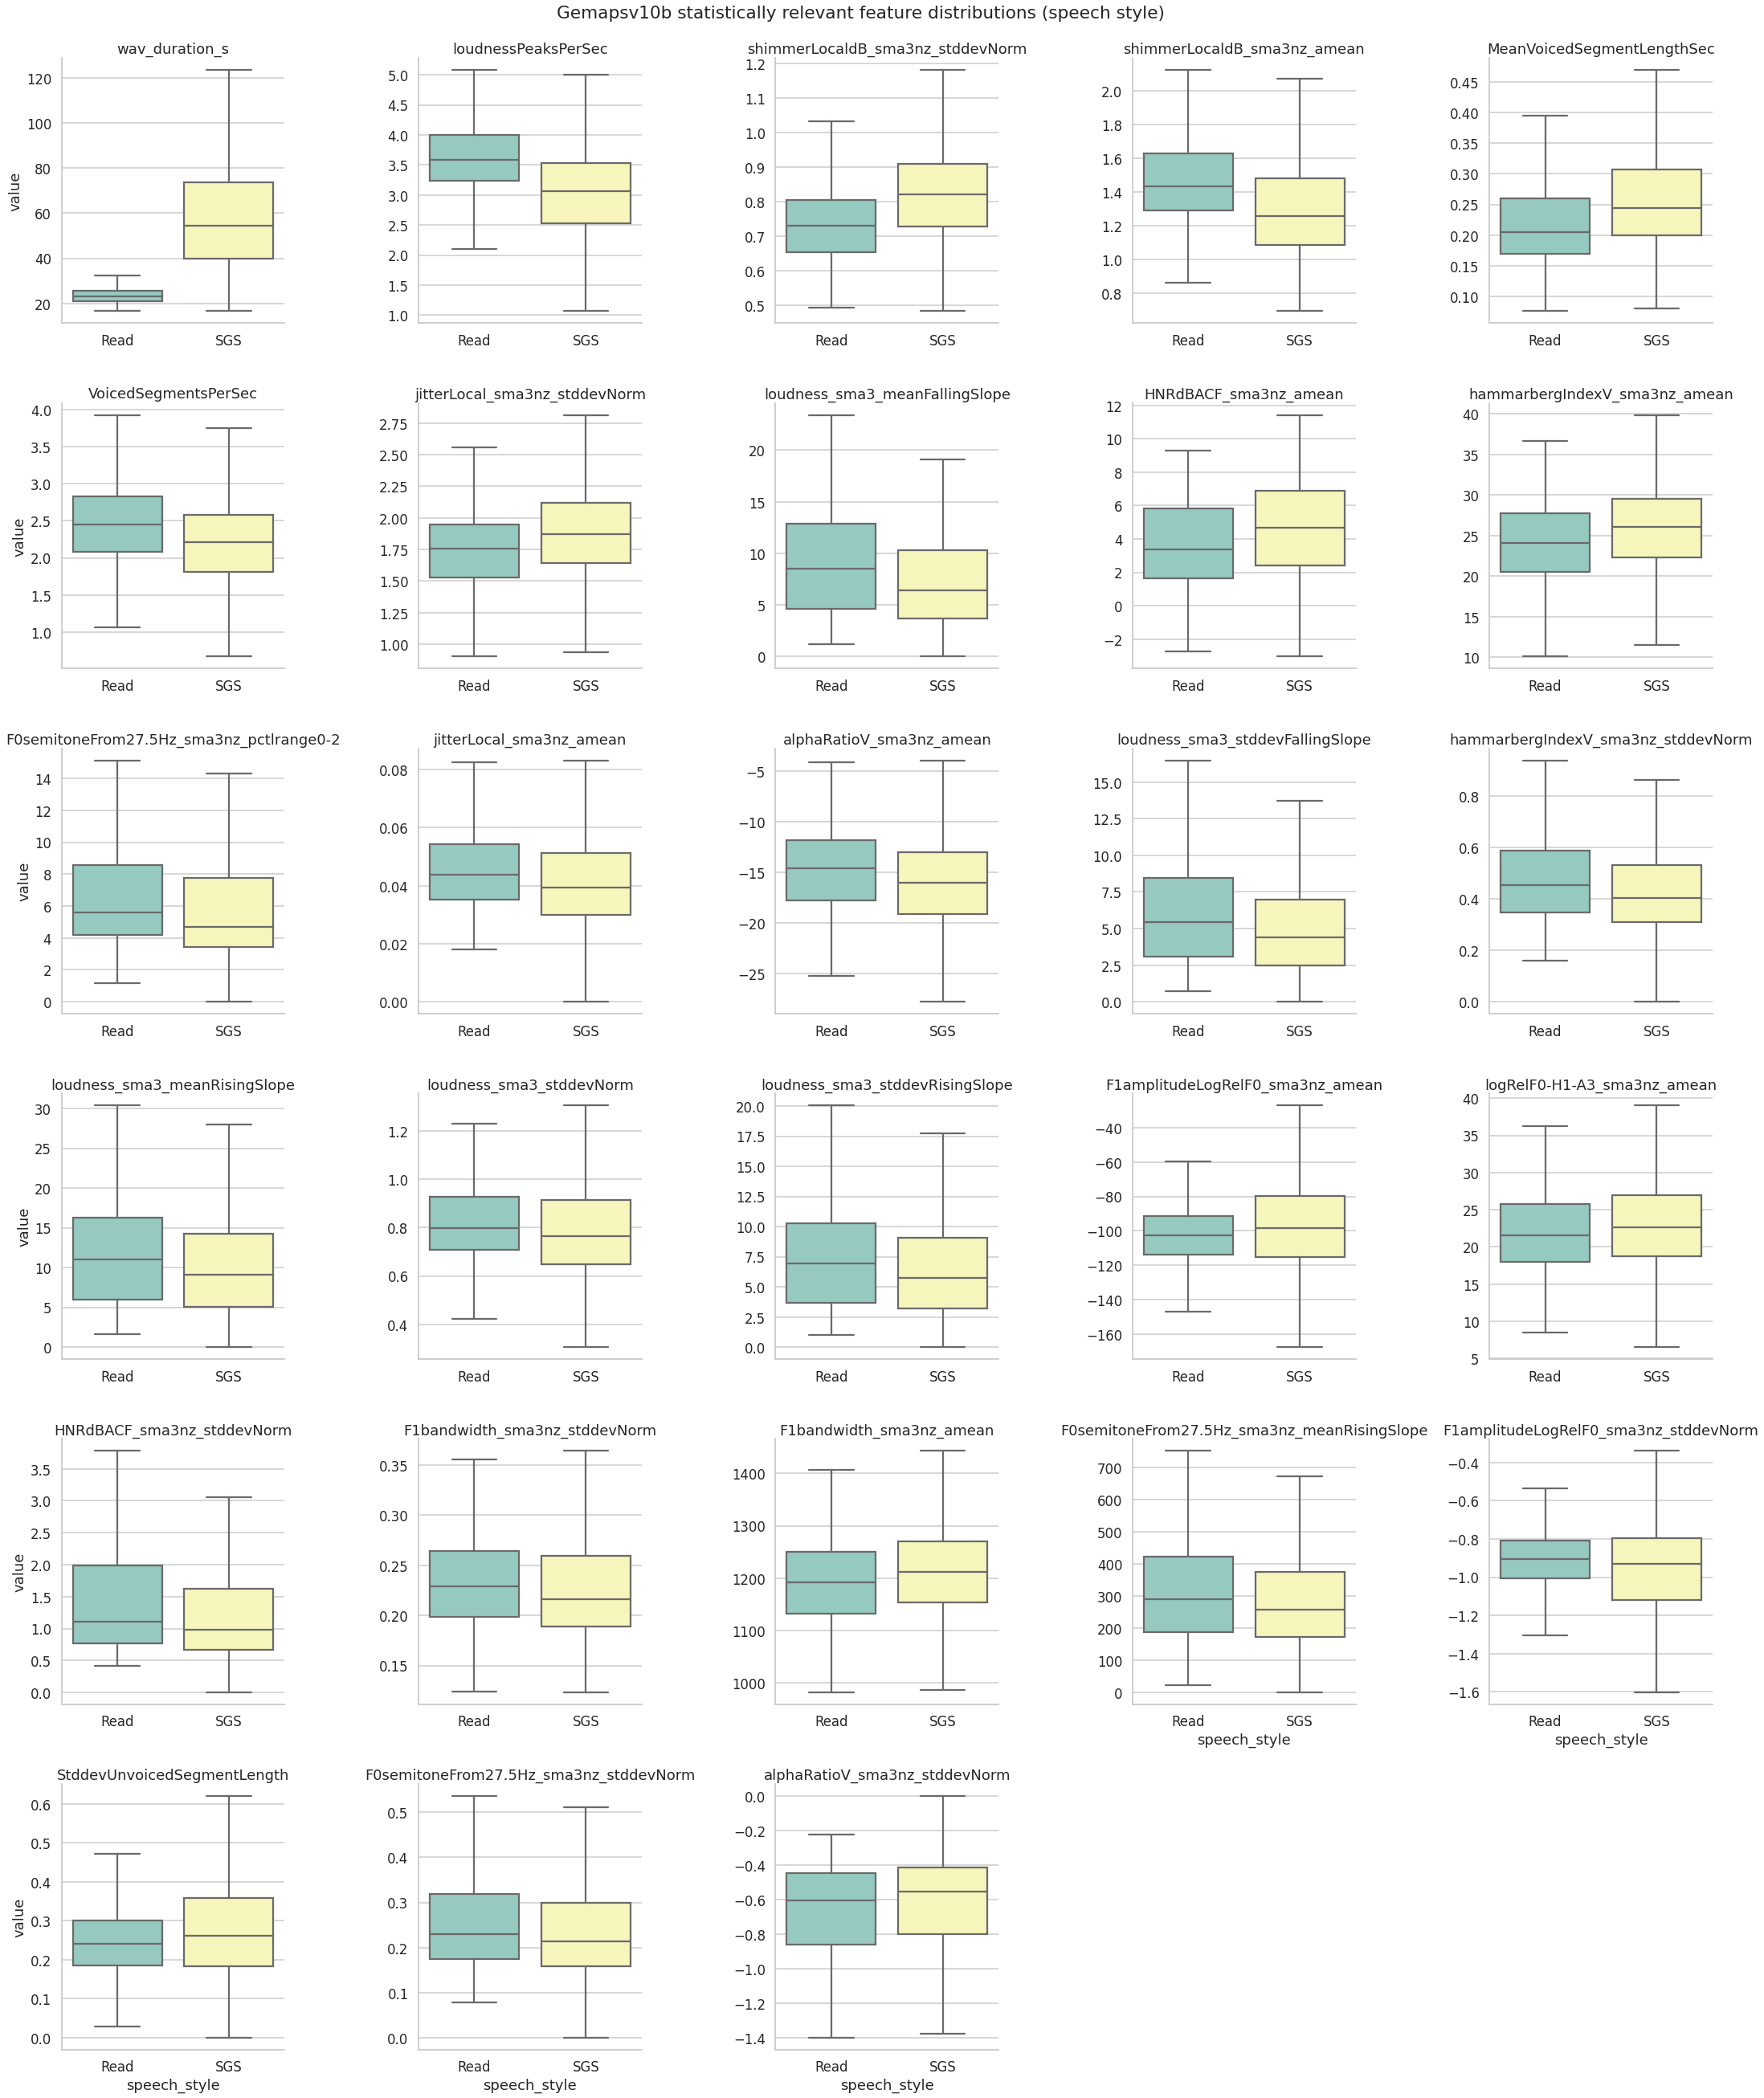

In [13]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_ss_rel[
            df_ss_rel.feature.isin(
                set(df_ss_rel.feature.values).difference(
                    # also to not visualize the LLD quantile's + counts
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="speech_style",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    sharex='row',
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions (speech style)", y=1.01
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


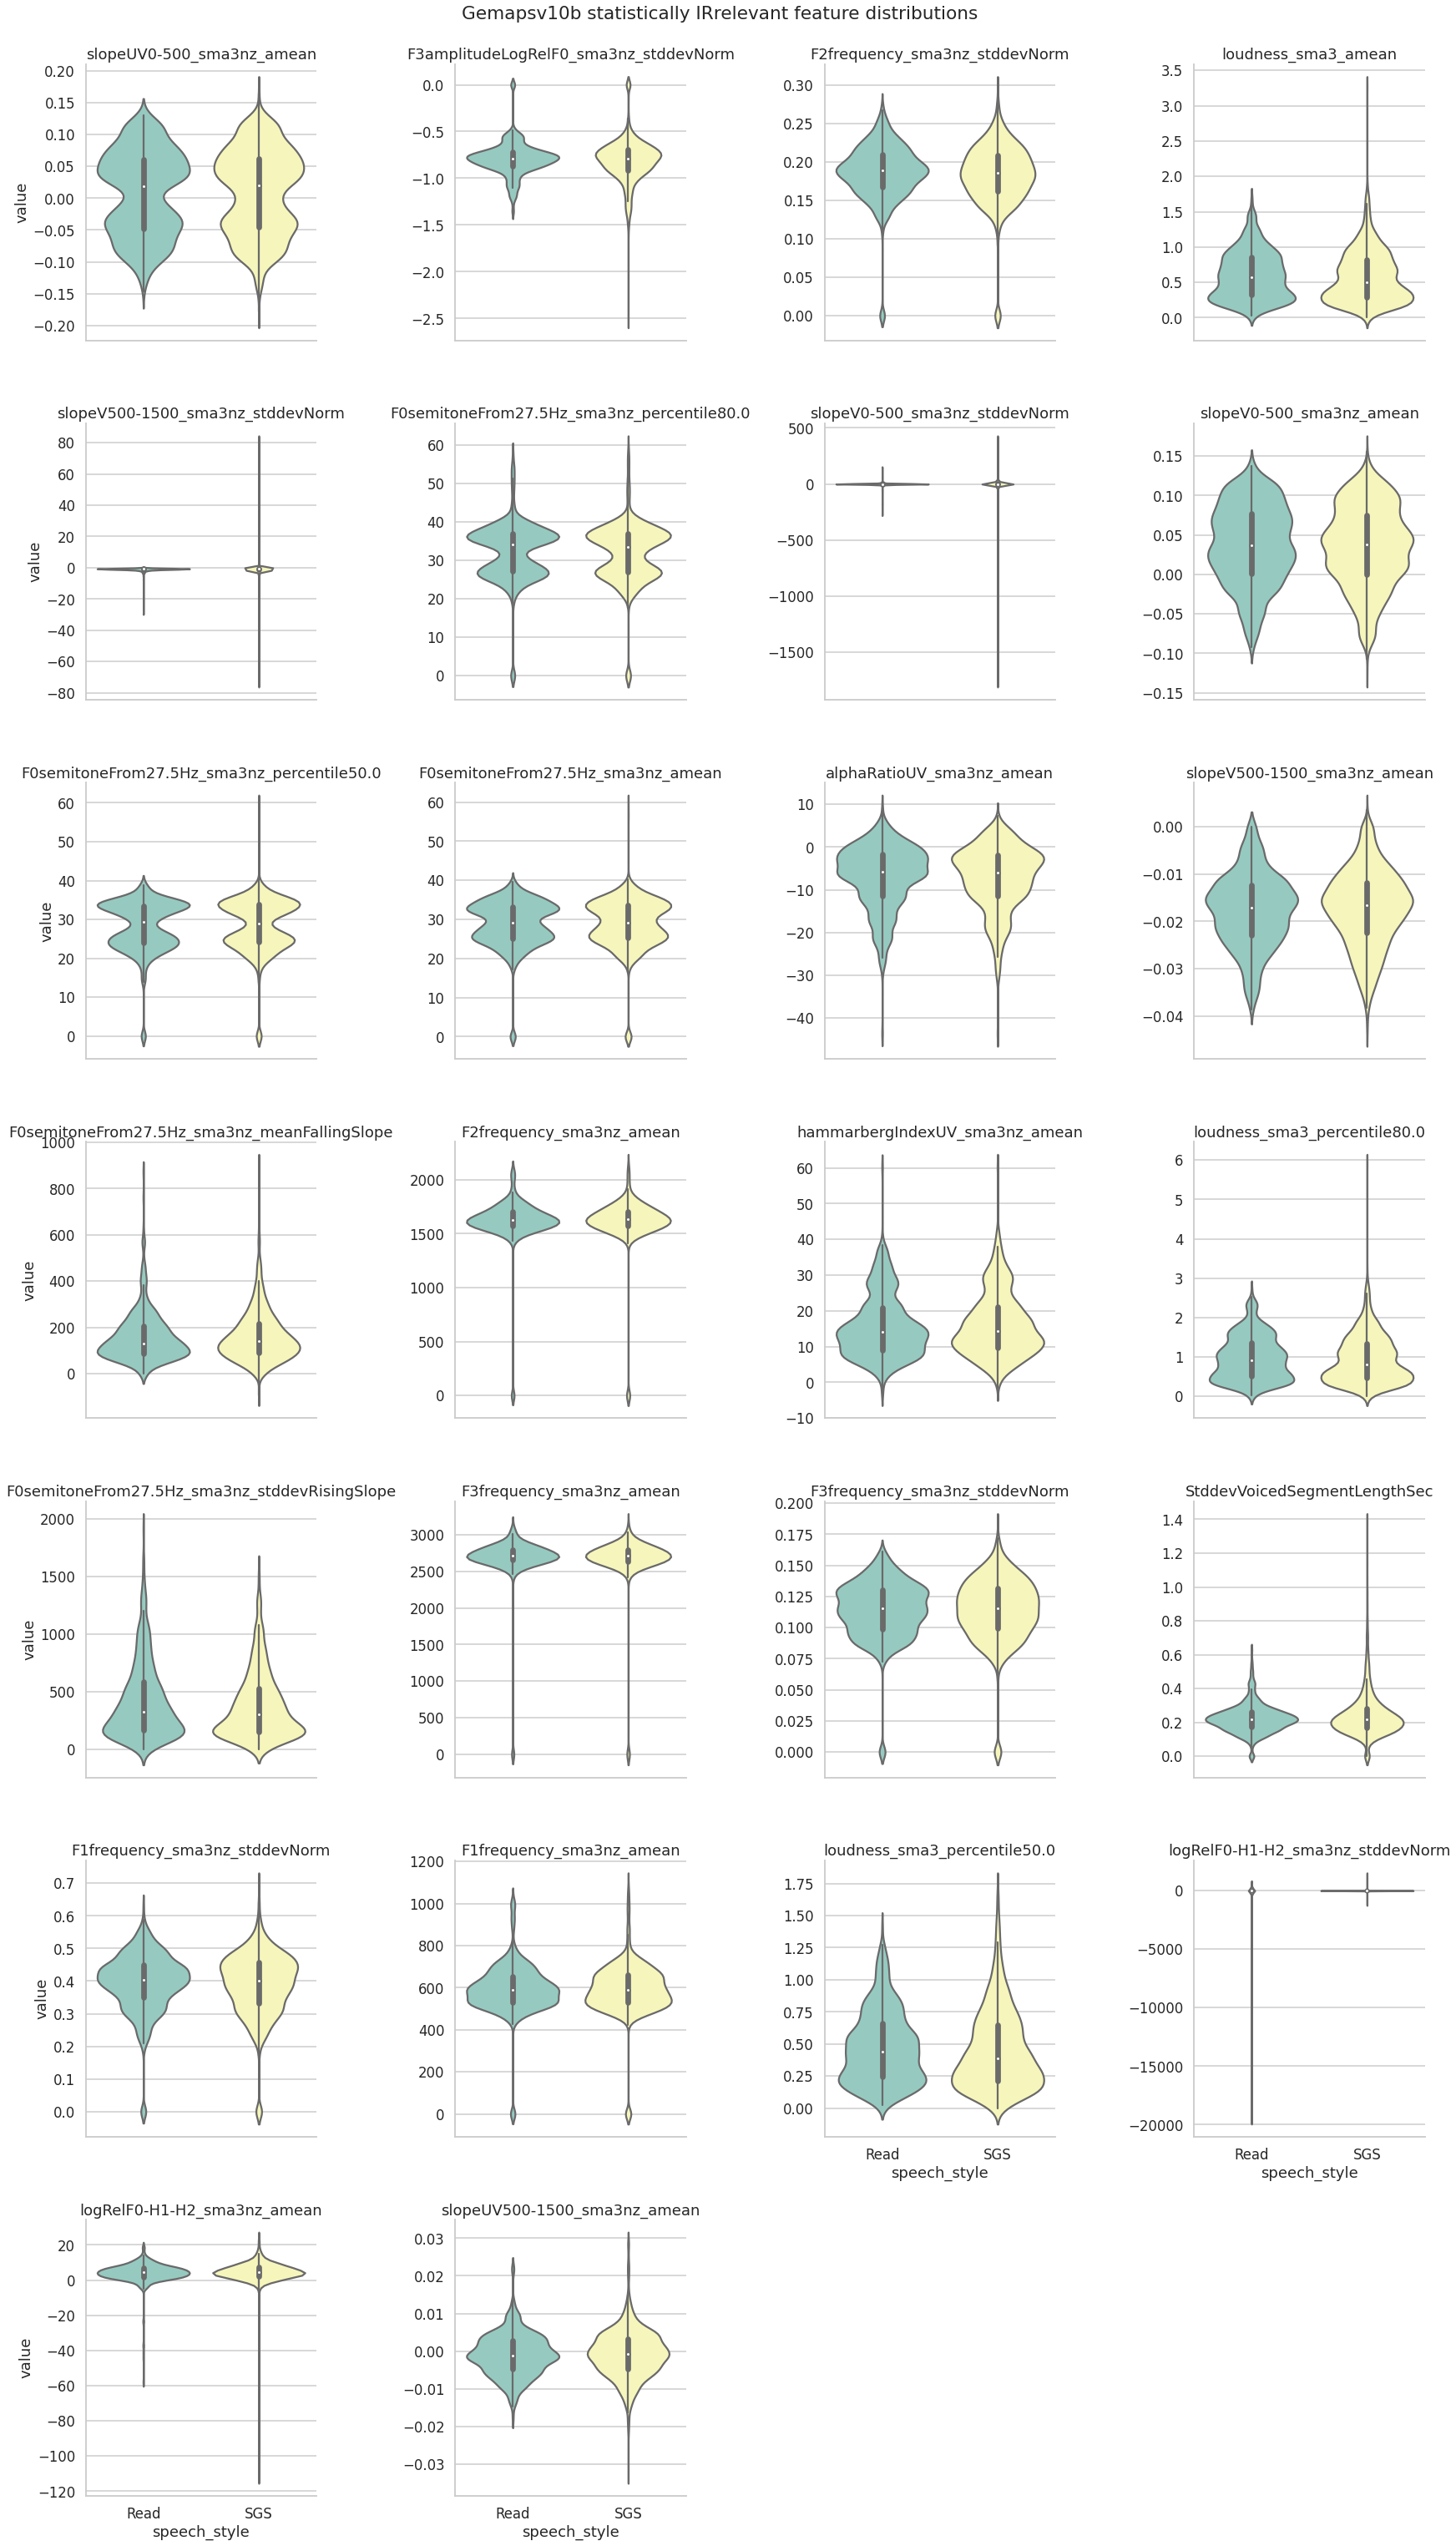

In [14]:
# The non-statiscially relevant features
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat,
        id_vars=id_vars,
        value_vars=set(df_session_feat.columns).difference(
            list(id_vars)
            + list(df_ss_rel_05.feature)
            # also to not visualize the LLD quantile's + counts
            + list(df_session_feat.filter(like="q=").columns.values)
            + list(df_session_feat.filter(like="qd=").columns.values)
            + list(df_session_feat.filter(like="nzcount").columns.values),
        ),
        value_name="value",
        var_name="v",
    ),
    x="speech_style",
    y="value",
    col="v",
    col_wrap=4,
    height=6,
    kind="violin",
    bw=0.2,
    palette="Set3",
    sharey=False,
)
g.fig.suptitle("Gemapsv10b statistically IRrelevant feature distributions", y=1.01)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Using `database` statistics (PiSCES, Marloes)

In [15]:
df_db_rel


feature       p_value
66                    loudnessPeaksPerSec  2.257363e-23
9               MeanUnvoicedSegmentLength  2.453087e-15
91                   VoicedSegmentsPerSec  9.052795e-13
39                         wav_duration_s  5.218735e-10
23            StddevUnvoicedSegmentLength  6.457751e-10
97                    F0final_sma_nzcount  3.035677e-08
33    F0semitoneFrom27.5Hz_sma3nz_nzcount  3.395188e-08
53       F1amplitudeLogRelF0_sma3nz_amean  1.512857e-07
11  F1amplitudeLogRelF0_sma3nz_stddevNorm  1.410227e-06
41       F3amplitudeLogRelF0_sma3nz_amean  1.515057e-06
64       F2amplitudeLogRelF0_sma3nz_amean  1.656993e-06
51  F3amplitudeLogRelF0_sma3nz_stddevNorm  4.831182e-05
28  F2amplitudeLogRelF0_sma3nz_stddevNorm  5.673425e-05
94           StddevVoicedSegmentLengthSec  8.340986e-05
57            shimmerLocaldB_sma3nz_amean  8.081769e-04

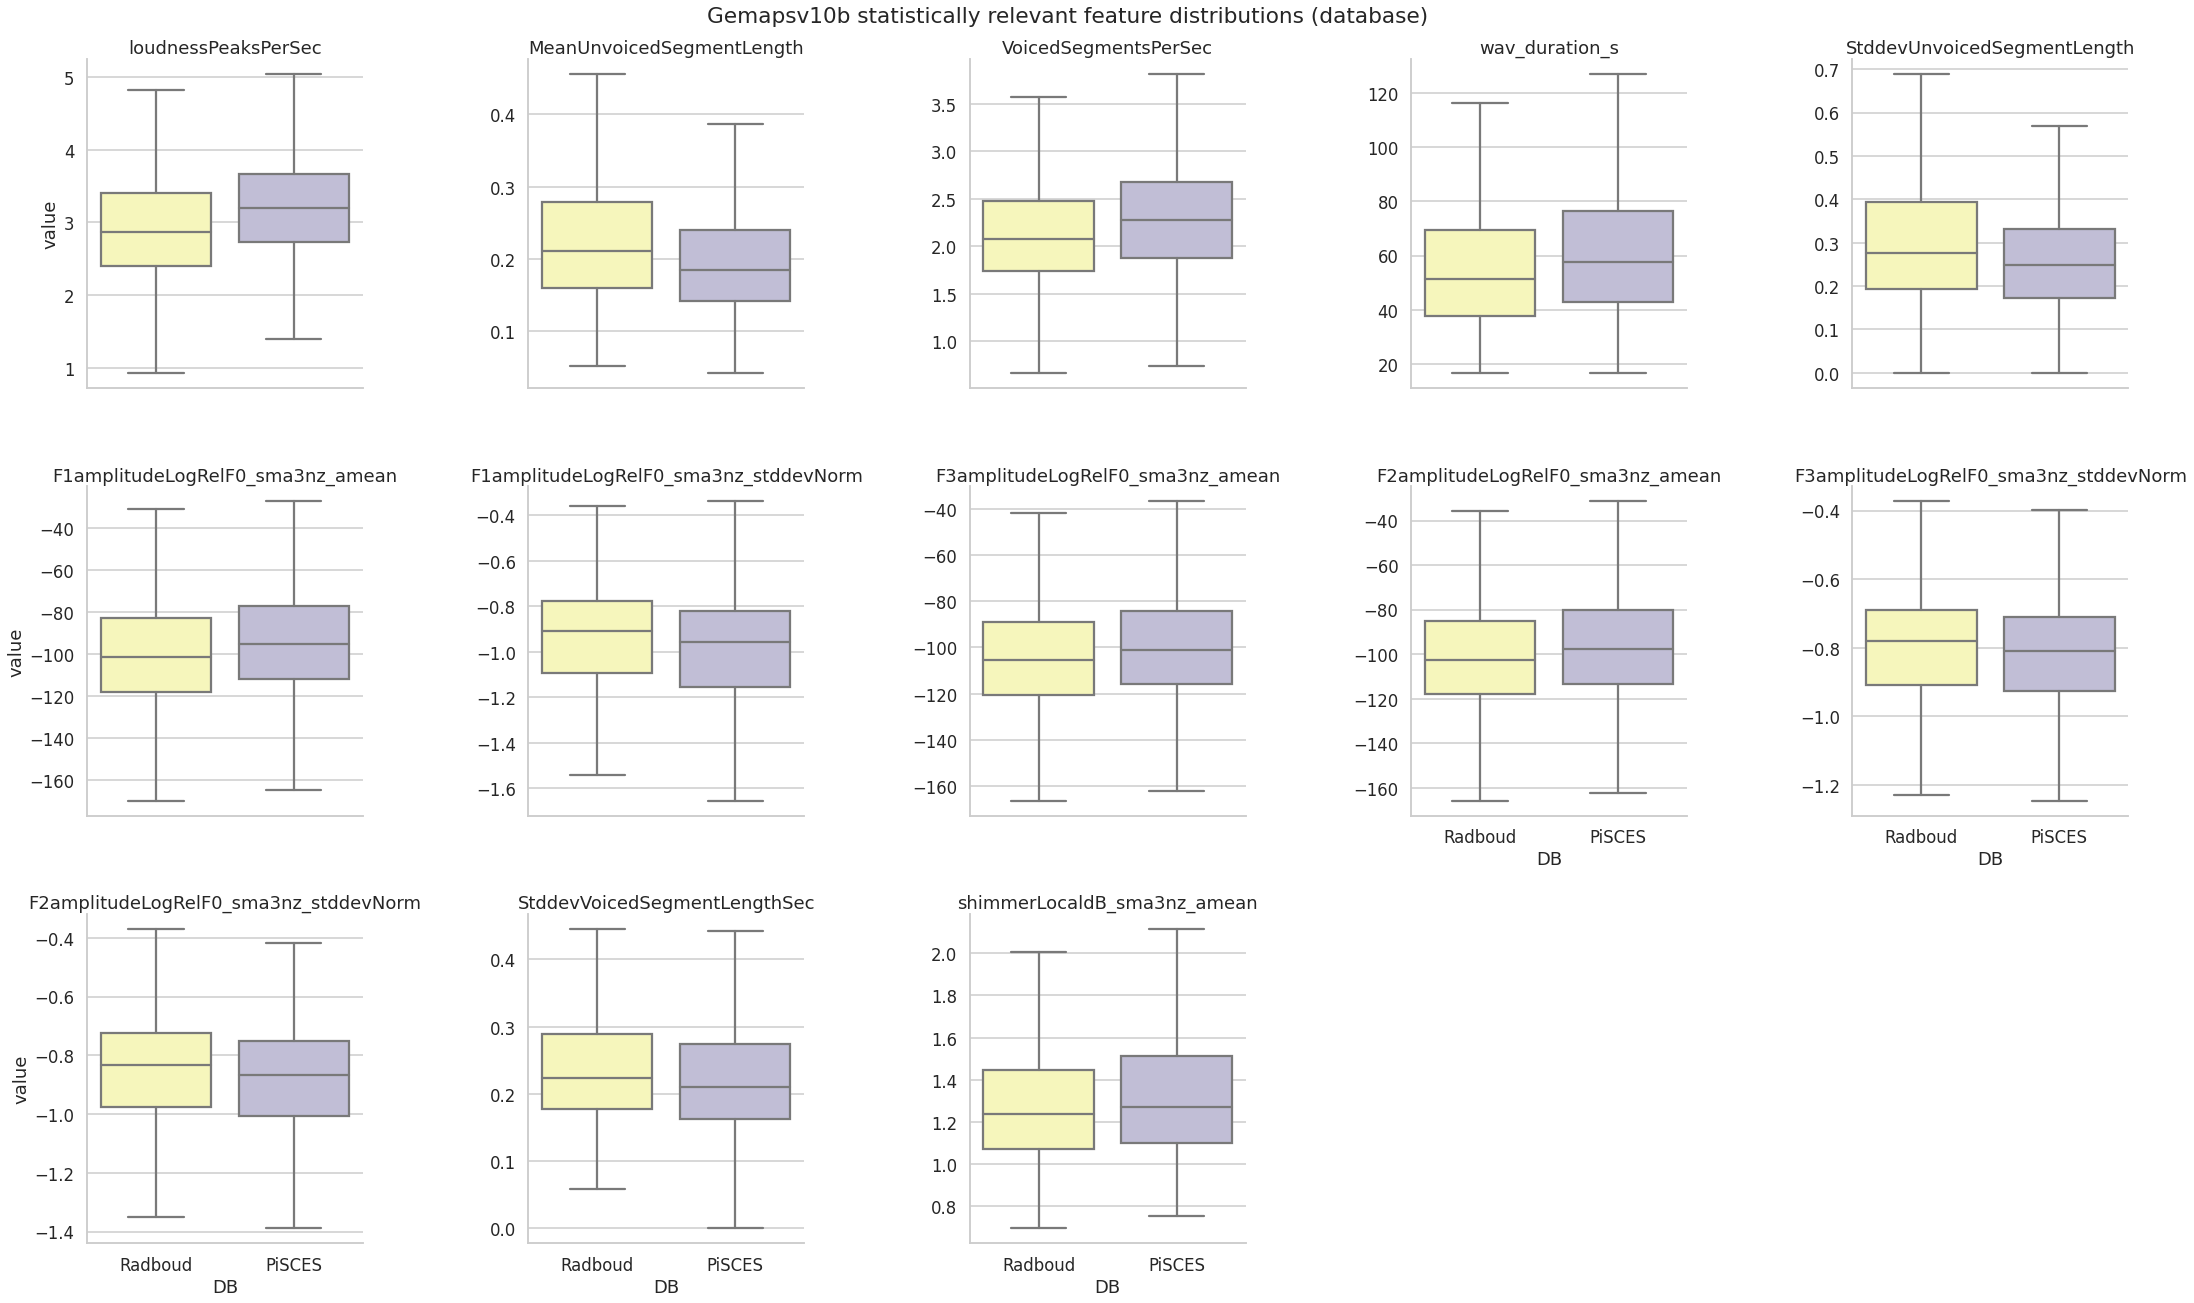

In [16]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask & (df_session.DB != "marloes")],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_db_rel[
            df_db_rel.feature.isin(
                set(df_db_rel.feature.values).difference(
                    # also to not visualize the LLD quantile's + counts
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette=sns.color_palette("Set3")[1:],
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions (database)", y=1.01
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


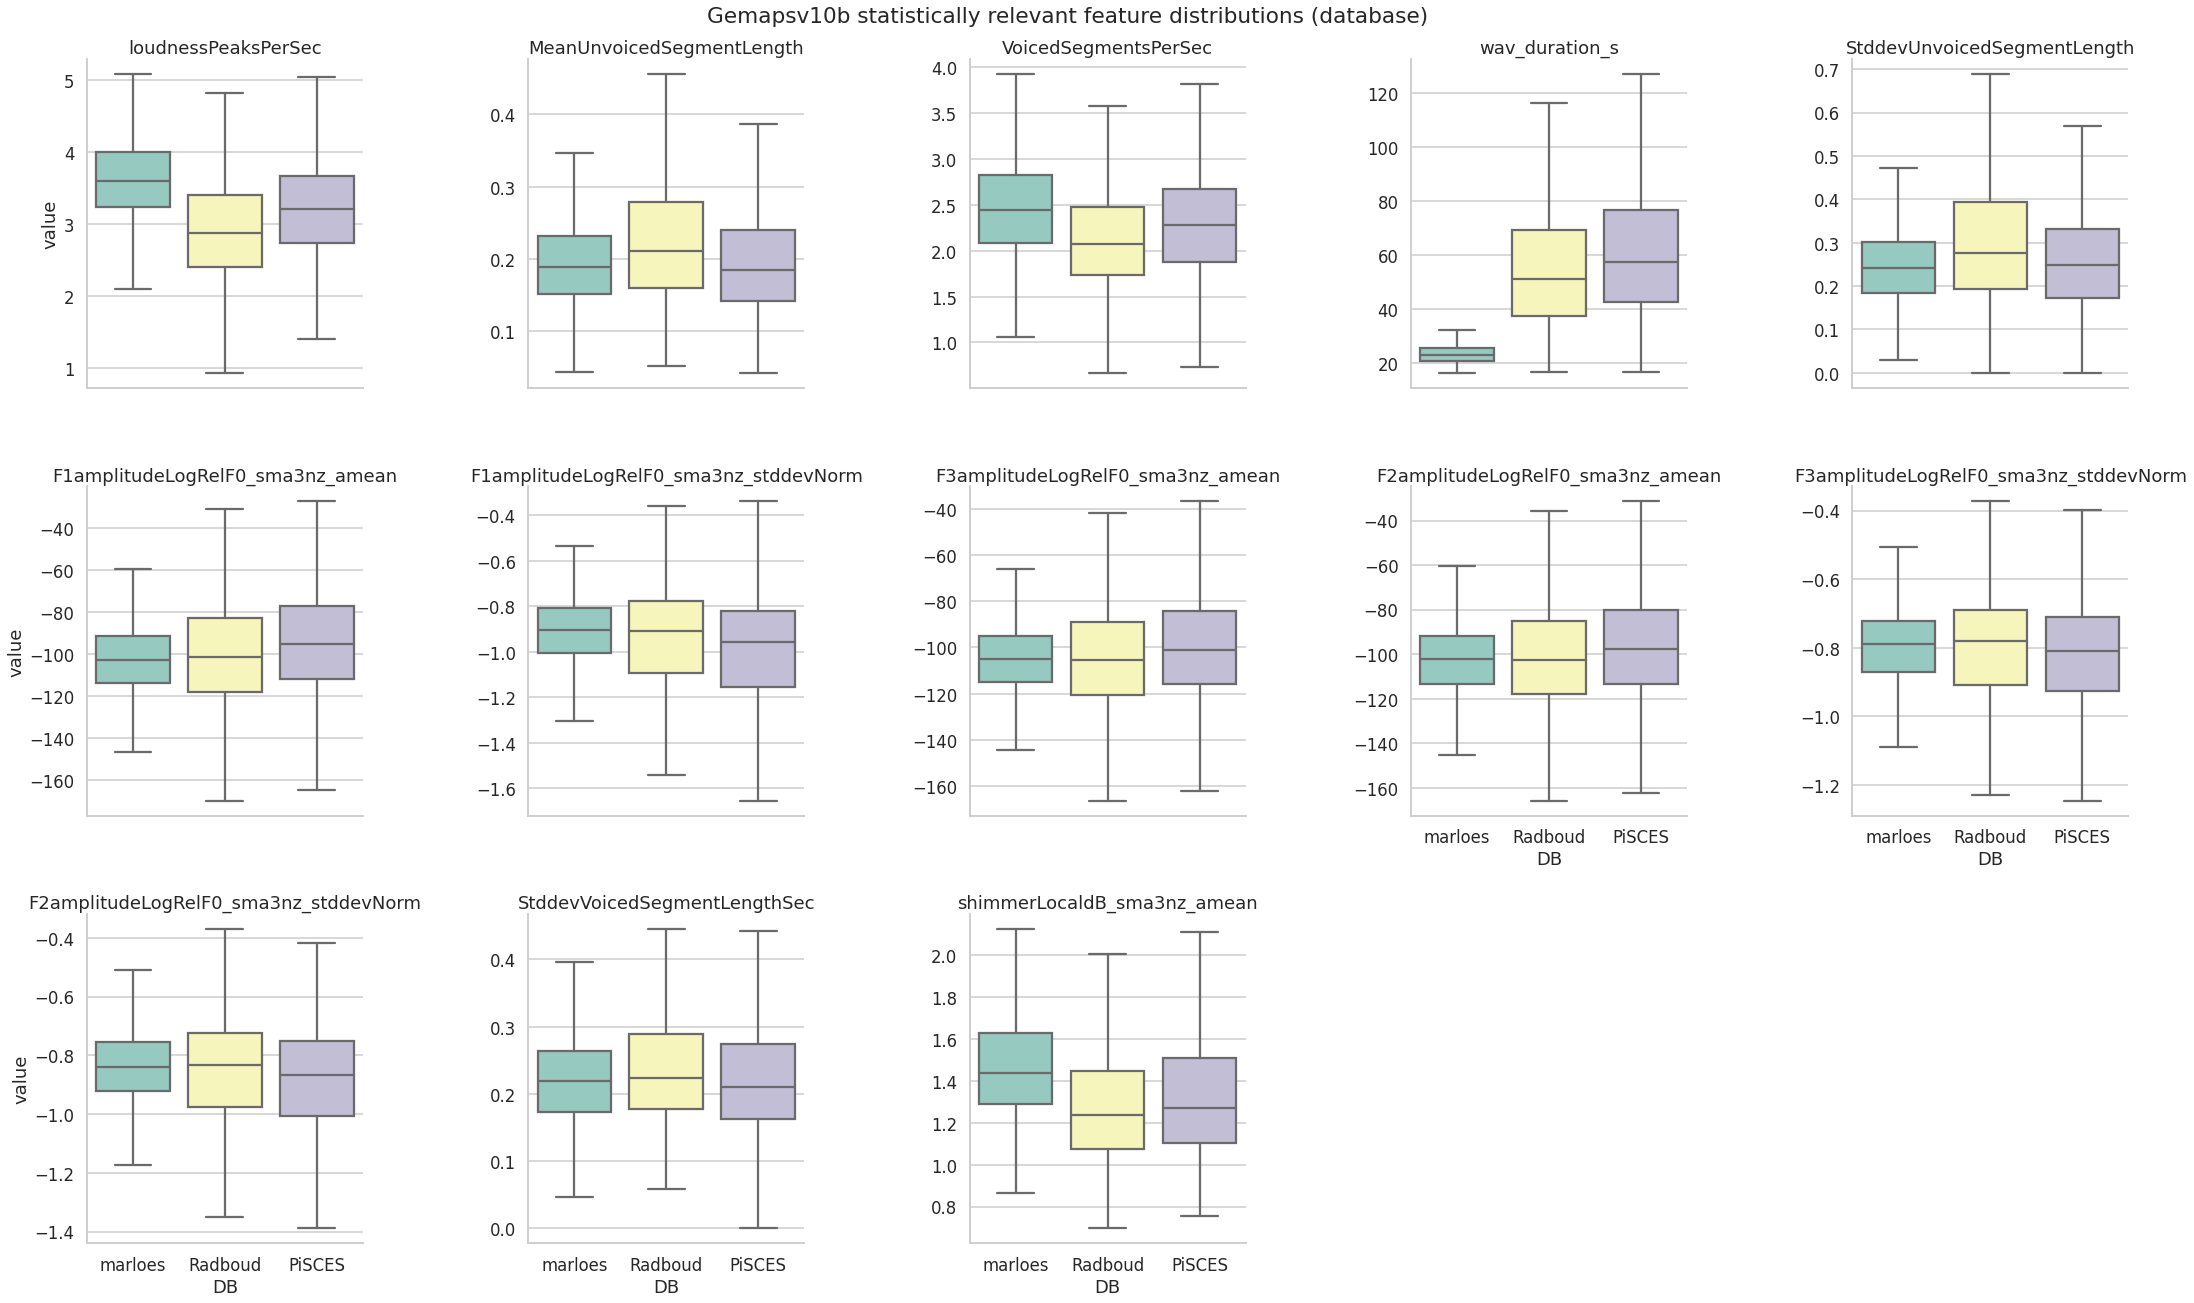

In [17]:
# same visualization as above, just added the marloes features for comparison
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_db_rel[
            df_db_rel.feature.isin(
                set(df_db_rel.feature.values).difference(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions (database)", y=1.01
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Statistically relevant speech beatures for both `speech_style` and `database` group

In [18]:
set(df_ss_rel.feature).intersection(df_db_rel.feature)


{'F0final_sma_nzcount',
 'F0semitoneFrom27.5Hz_sma3nz_nzcount',
 'F1amplitudeLogRelF0_sma3nz_amean',
 'F1amplitudeLogRelF0_sma3nz_stddevNorm',
 'StddevUnvoicedSegmentLength',
 'VoicedSegmentsPerSec',
 'loudnessPeaksPerSec',
 'shimmerLocaldB_sma3nz_amean',
 'wav_duration_s'}

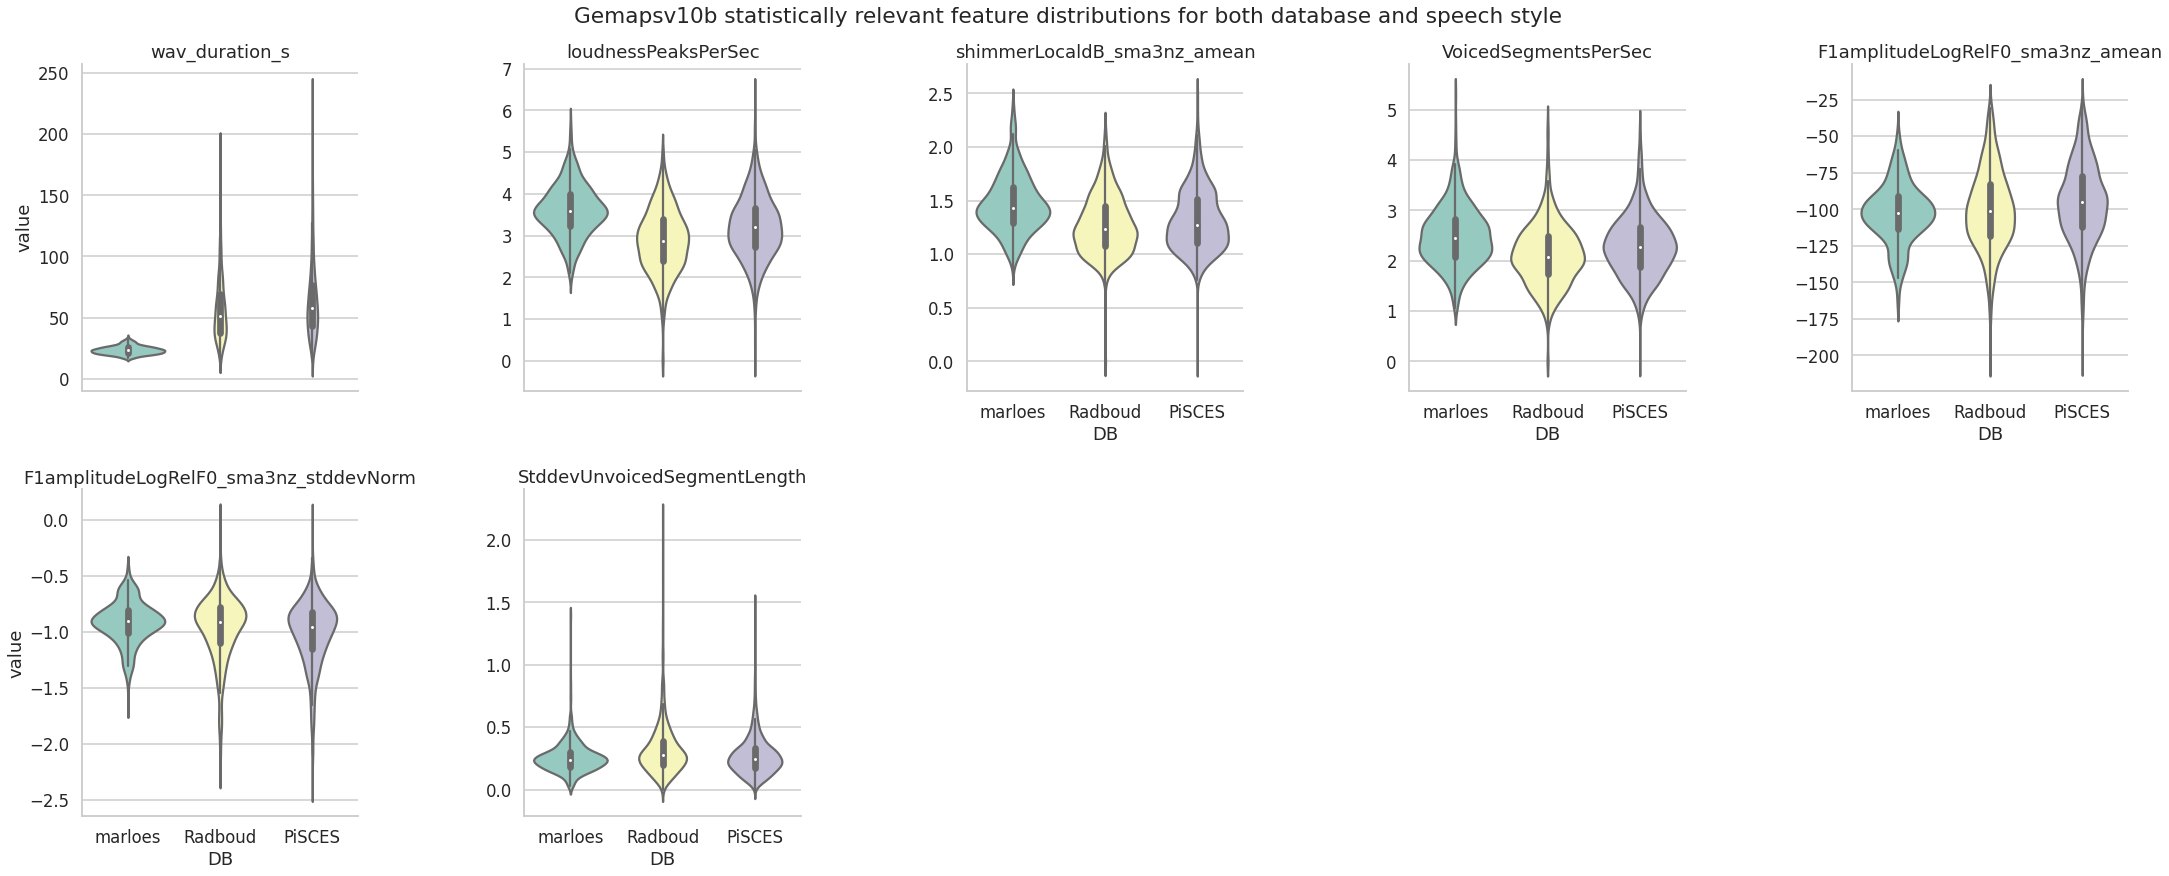

In [19]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_ss_rel[
            df_ss_rel.feature.isin(
                set(df_ss_rel.feature.values)
                .intersection(df_db_rel.feature)
                .difference(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="violin",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions for both database and speech style",
    y=1.02,
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


**insights**: The trend between thee `marloes` <-> `not-marloes` seems the same in most features

### Statistically relevant speech features for `speech_style`, but not for `database` group

In [20]:
# Features which are statistically different within the `speech_style` group and not within the `database` group
set(df_ss_rel.feature).difference(df_db_rel.feature)


{'F0final_sma_q=0',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_q=0',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F1bandwidth_sma3nz_amean',
 'F1bandwidth_sma3nz_stddevNorm',
 'HNRdBACF_sma3nz_amean',
 'HNRdBACF_sma3nz_stddevNorm',
 'MeanVoicedSegmentLengthSec',
 'alphaRatioV_sma3nz_amean',
 'alphaRatioV_sma3nz_stddevNorm',
 'hammarbergIndexV_sma3nz_amean',
 'hammarbergIndexV_sma3nz_stddevNorm',
 'jitterLocal_sma3nz_amean',
 'jitterLocal_sma3nz_stddevNorm',
 'logRelF0-H1-A3_sma3nz_amean',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevFallingSlope',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_stddevRisingSlope',
 'shimmerLocaldB_sma3nz_stddevNorm'}

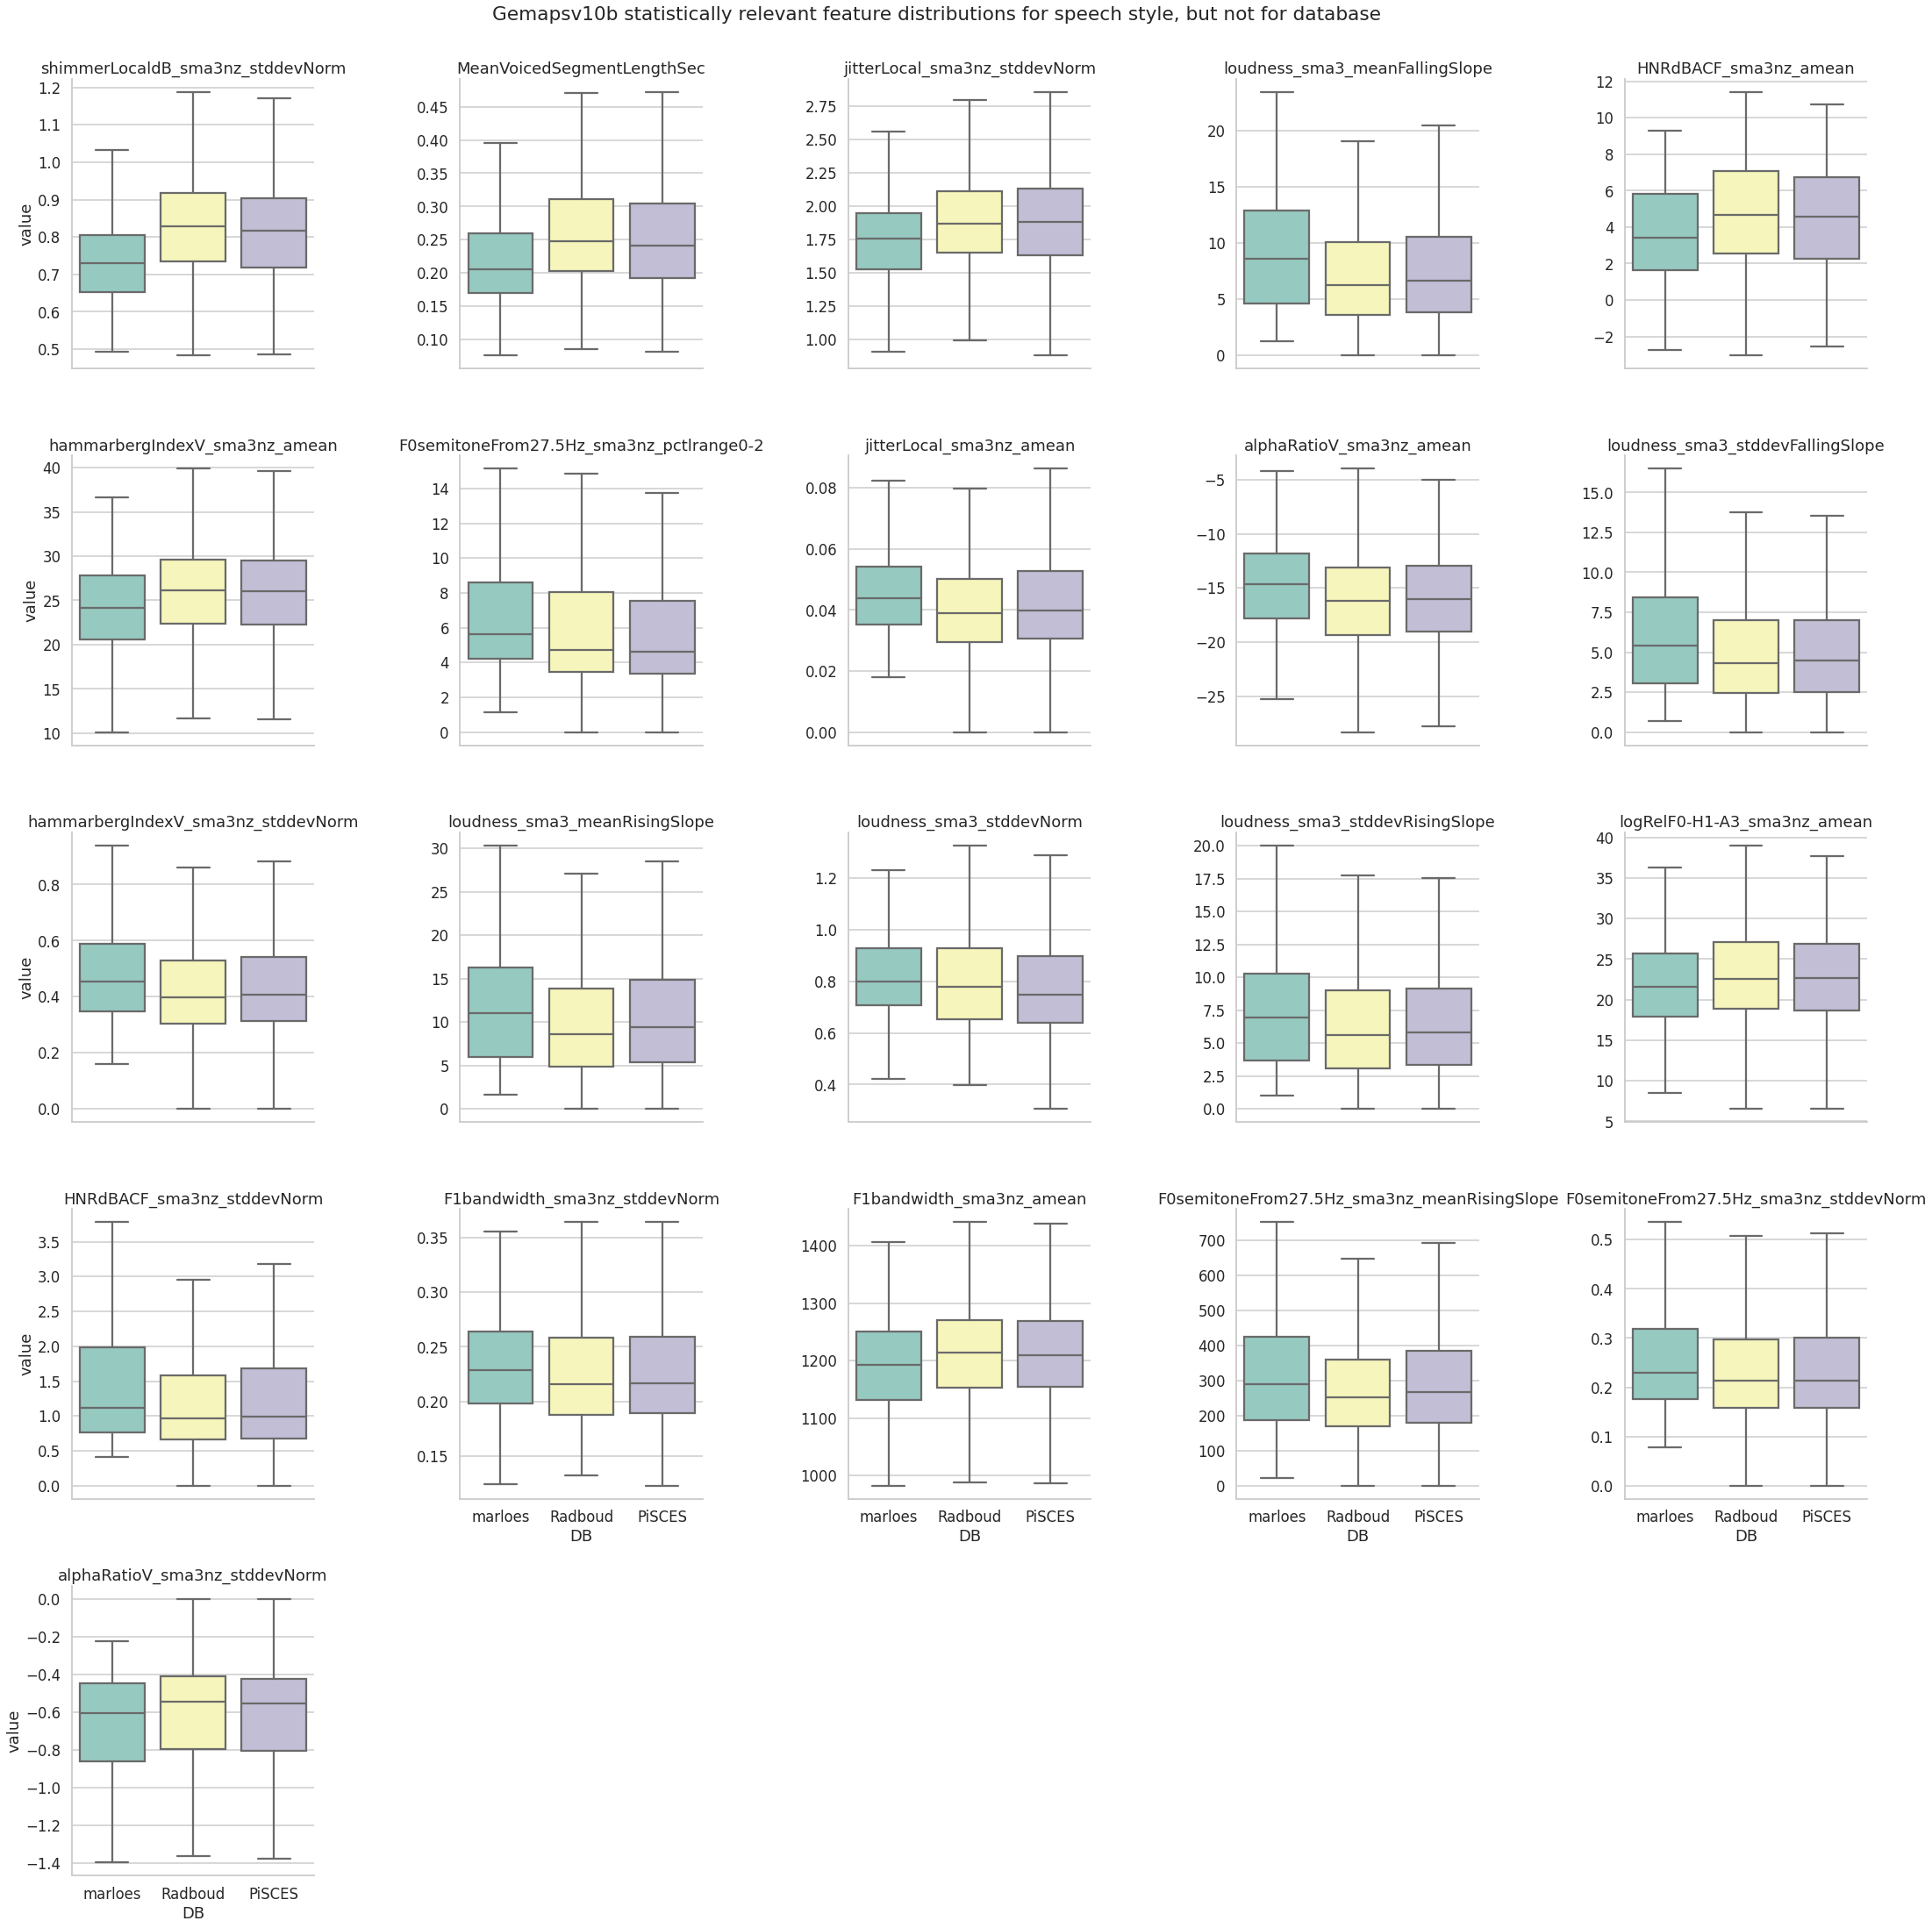

In [21]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        value_vars=df_ss_rel[
            df_ss_rel.feature.isin(
                set(df_ss_rel.feature.values)
                .difference(df_db_rel.feature)
                .difference(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions for speech style, but not for database",
    y=1.02,
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Statistically relevant speech beatures for `database`, but not for `speech_style` group

In [22]:
# Features which are only statiscilly different within the `database` group, but not in in the `speech_style` group
set(df_db_rel.feature).difference(df_ss_rel.feature)


{'F2amplitudeLogRelF0_sma3nz_amean',
 'F2amplitudeLogRelF0_sma3nz_stddevNorm',
 'F3amplitudeLogRelF0_sma3nz_amean',
 'F3amplitudeLogRelF0_sma3nz_stddevNorm',
 'MeanUnvoicedSegmentLength',
 'StddevVoicedSegmentLengthSec'}

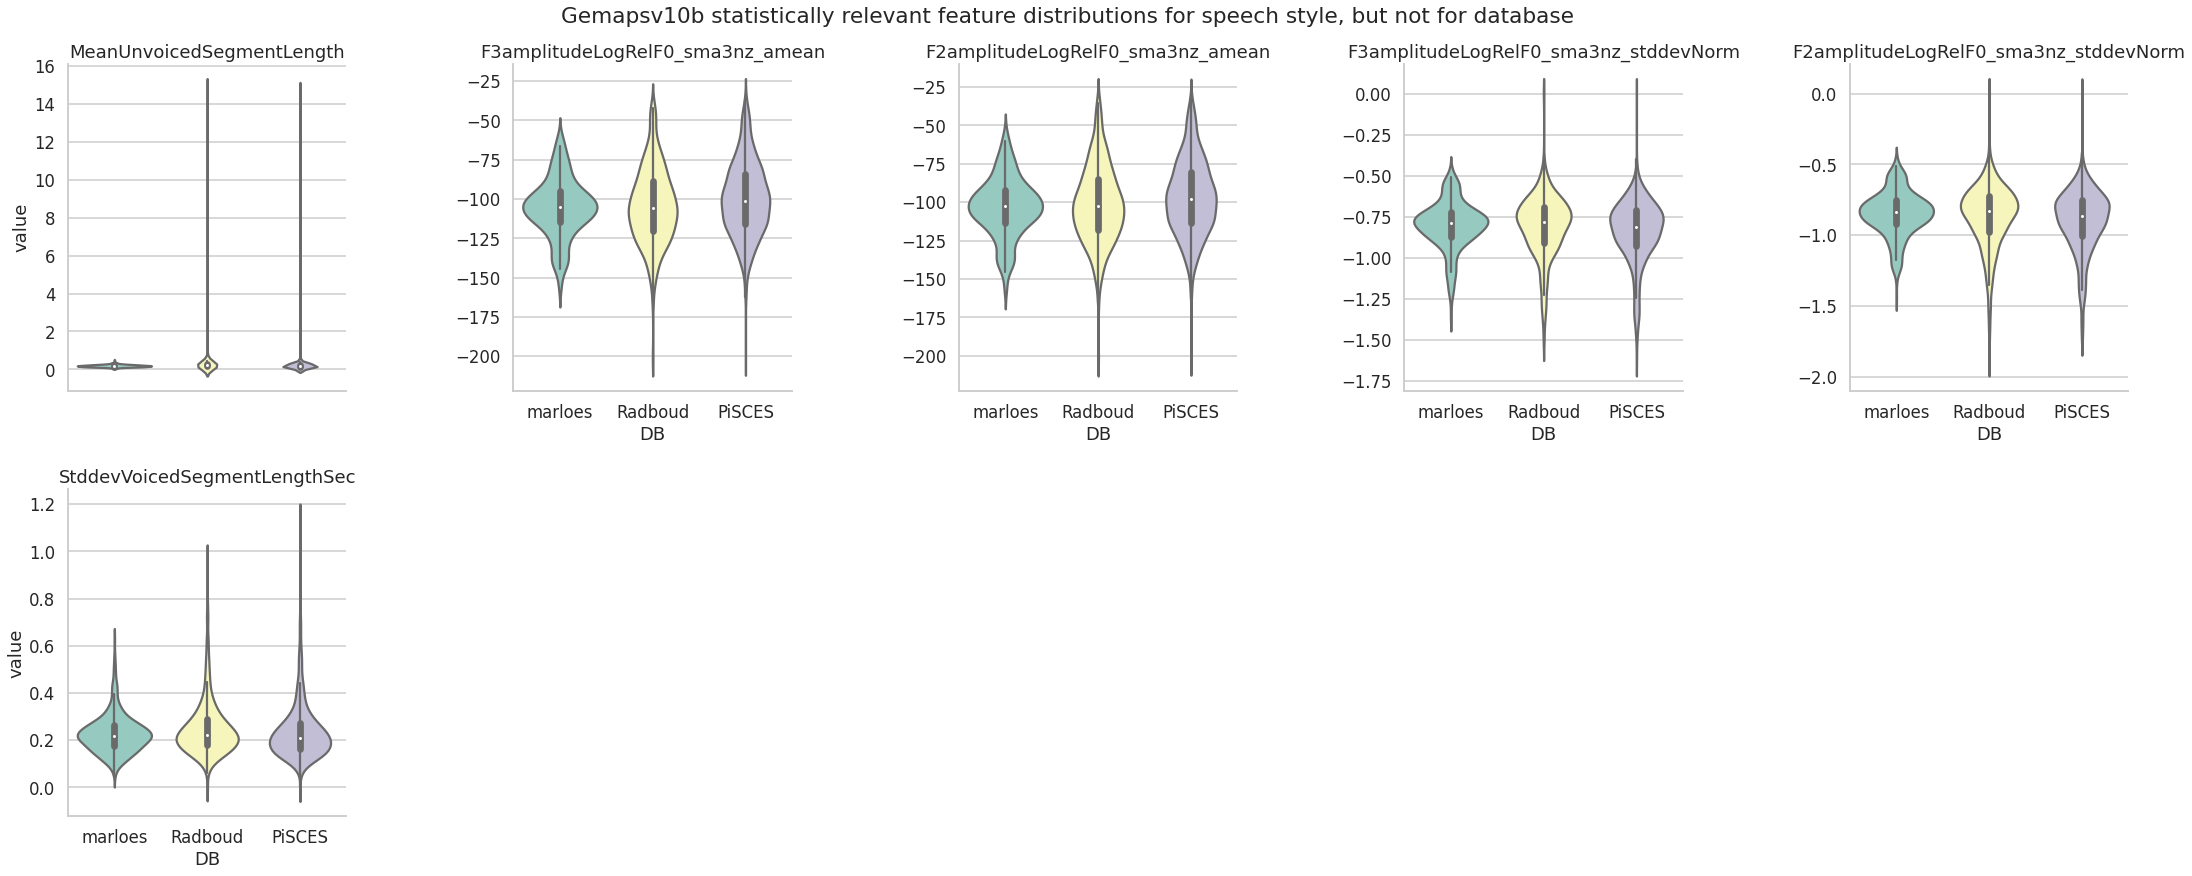

In [23]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        value_vars=df_db_rel[
            df_db_rel.feature.isin(
                set(df_db_rel.feature.values)
                .difference(df_ss_rel.feature)
                .difference(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="violin",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions for speech style, but not for database",
    y=1.02,
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


## Intra user comparison: (mean) normalization per participant

In [24]:
# calculate the mean per participant, per block
# TODO -> maybe use the reference values? and subtract the control / stress block
# from these reference values

# --------------- on speech_style level ----------------
mean_func = (
    df_session_feat[valid_mask]
    .groupby(["ID", "speech_style"])[
        list(set(df_session_feat.columns).difference(id_vars))
    ]
    .mean()
    .reset_index()
)

mean_sgs_func = mean_func[mean_func.speech_style == "SGS"].set_index("ID")
mean_read_func = mean_func[mean_func.speech_style == "Read"].set_index("ID")

feat_cols: List[str] = list(
    set(df_session_feat.columns).difference(
        id_vars
        + list(df_session_feat.filter(like="q=").columns.values)
        + list(df_session_feat.filter(like="qd=").columns.values)
        + list(df_session_feat.filter(like="nzcount").columns.values),
    )
)

mean_read_sgs_func = mean_read_func[feat_cols] - mean_sgs_func[feat_cols]


# ---------------------- on database level ----------------
mean_func = (
    df_session_feat[valid_mask]
    .groupby(["ID", "DB"])[list(set(df_session_feat.columns).difference(id_vars))]
    .mean()
    .reset_index()
)
mean_marloes_func = mean_func[mean_func.DB == "marloes"].set_index("ID")
mean_radboud_func = mean_func[mean_func.DB == "Radboud"].set_index("ID")
mean_pisces_func = mean_func[mean_func.DB == "PiSCES"].set_index("ID")

mean_db_func = [
    (mean_marloes_func[feat_cols] - mean_radboud_func[feat_cols]).assign(delta="M-R")
]
mean_db_func.append(
    (mean_marloes_func[feat_cols] - mean_pisces_func[feat_cols]).assign(delta="M-P")
)
mean_db_func.append(
    (mean_radboud_func[feat_cols] - mean_pisces_func[feat_cols]).assign(delta="R-P")
)
mean_db_func = pd.concat(mean_db_func)


### `speech_style`: sgs vs. read

In [25]:
feat_score_list = []
for feat in mean_read_sgs_func.columns:
    test = wilcoxon(
        x=mean_read_sgs_func[feat].values, alternative="two-sided", nan_policy="omit"
    )
    feat_score_list.append([feat, test.pvalue])

df_i = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_i_rel = df_i[df_i.p_value < 0.001]
df_i_rel_05 = df_i[df_i.p_value < 0.05]


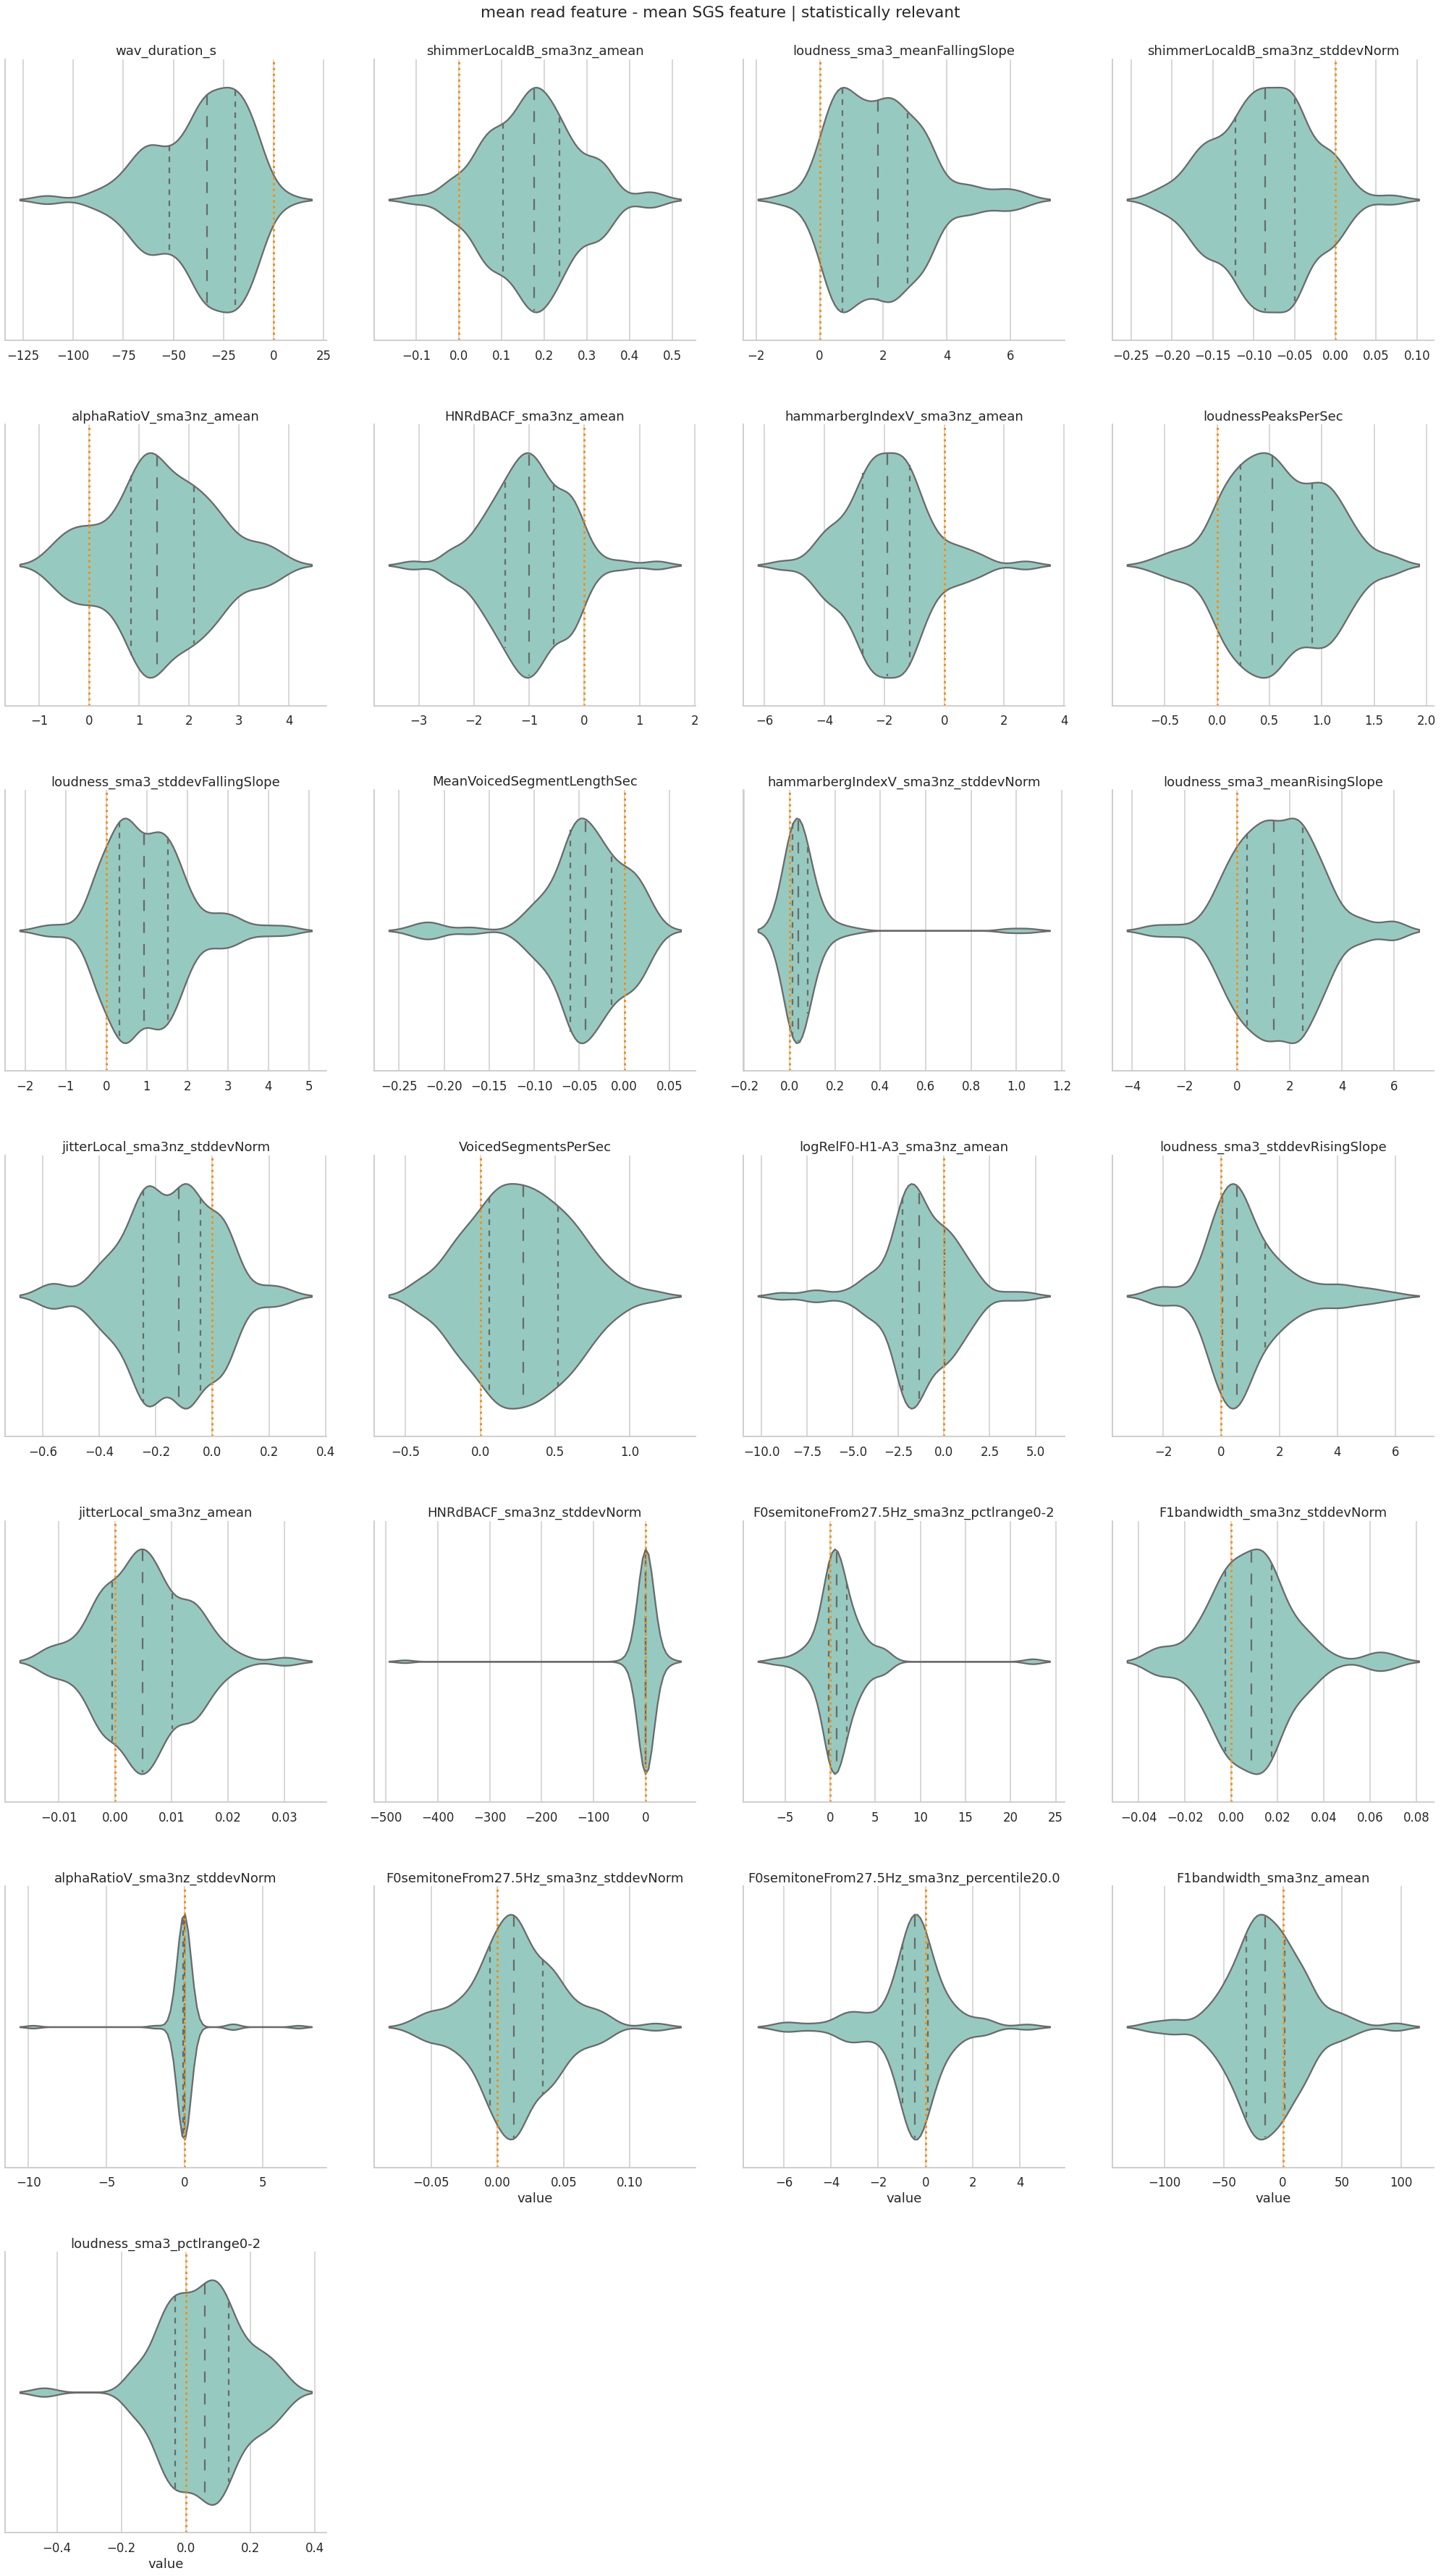

In [26]:
g = sns.catplot(
    data=mean_read_sgs_func[df_i_rel.feature.values].iloc[:, :].melt(var_name="v"),
    col="v",
    x="value",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle("mean read feature - mean SGS feature | statistically relevant", y=1.01)
g.set_titles("{col_name}")
for ax in g.fig.axes:
    ax.axvline(x=0, color="darkorange", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)


None of the features seem to be statistically irrelevant

In [27]:
set(df_i_rel.feature.values).difference(mean_read_sgs_func.columns)


set()

### `database` delta's **! beautiful figure**

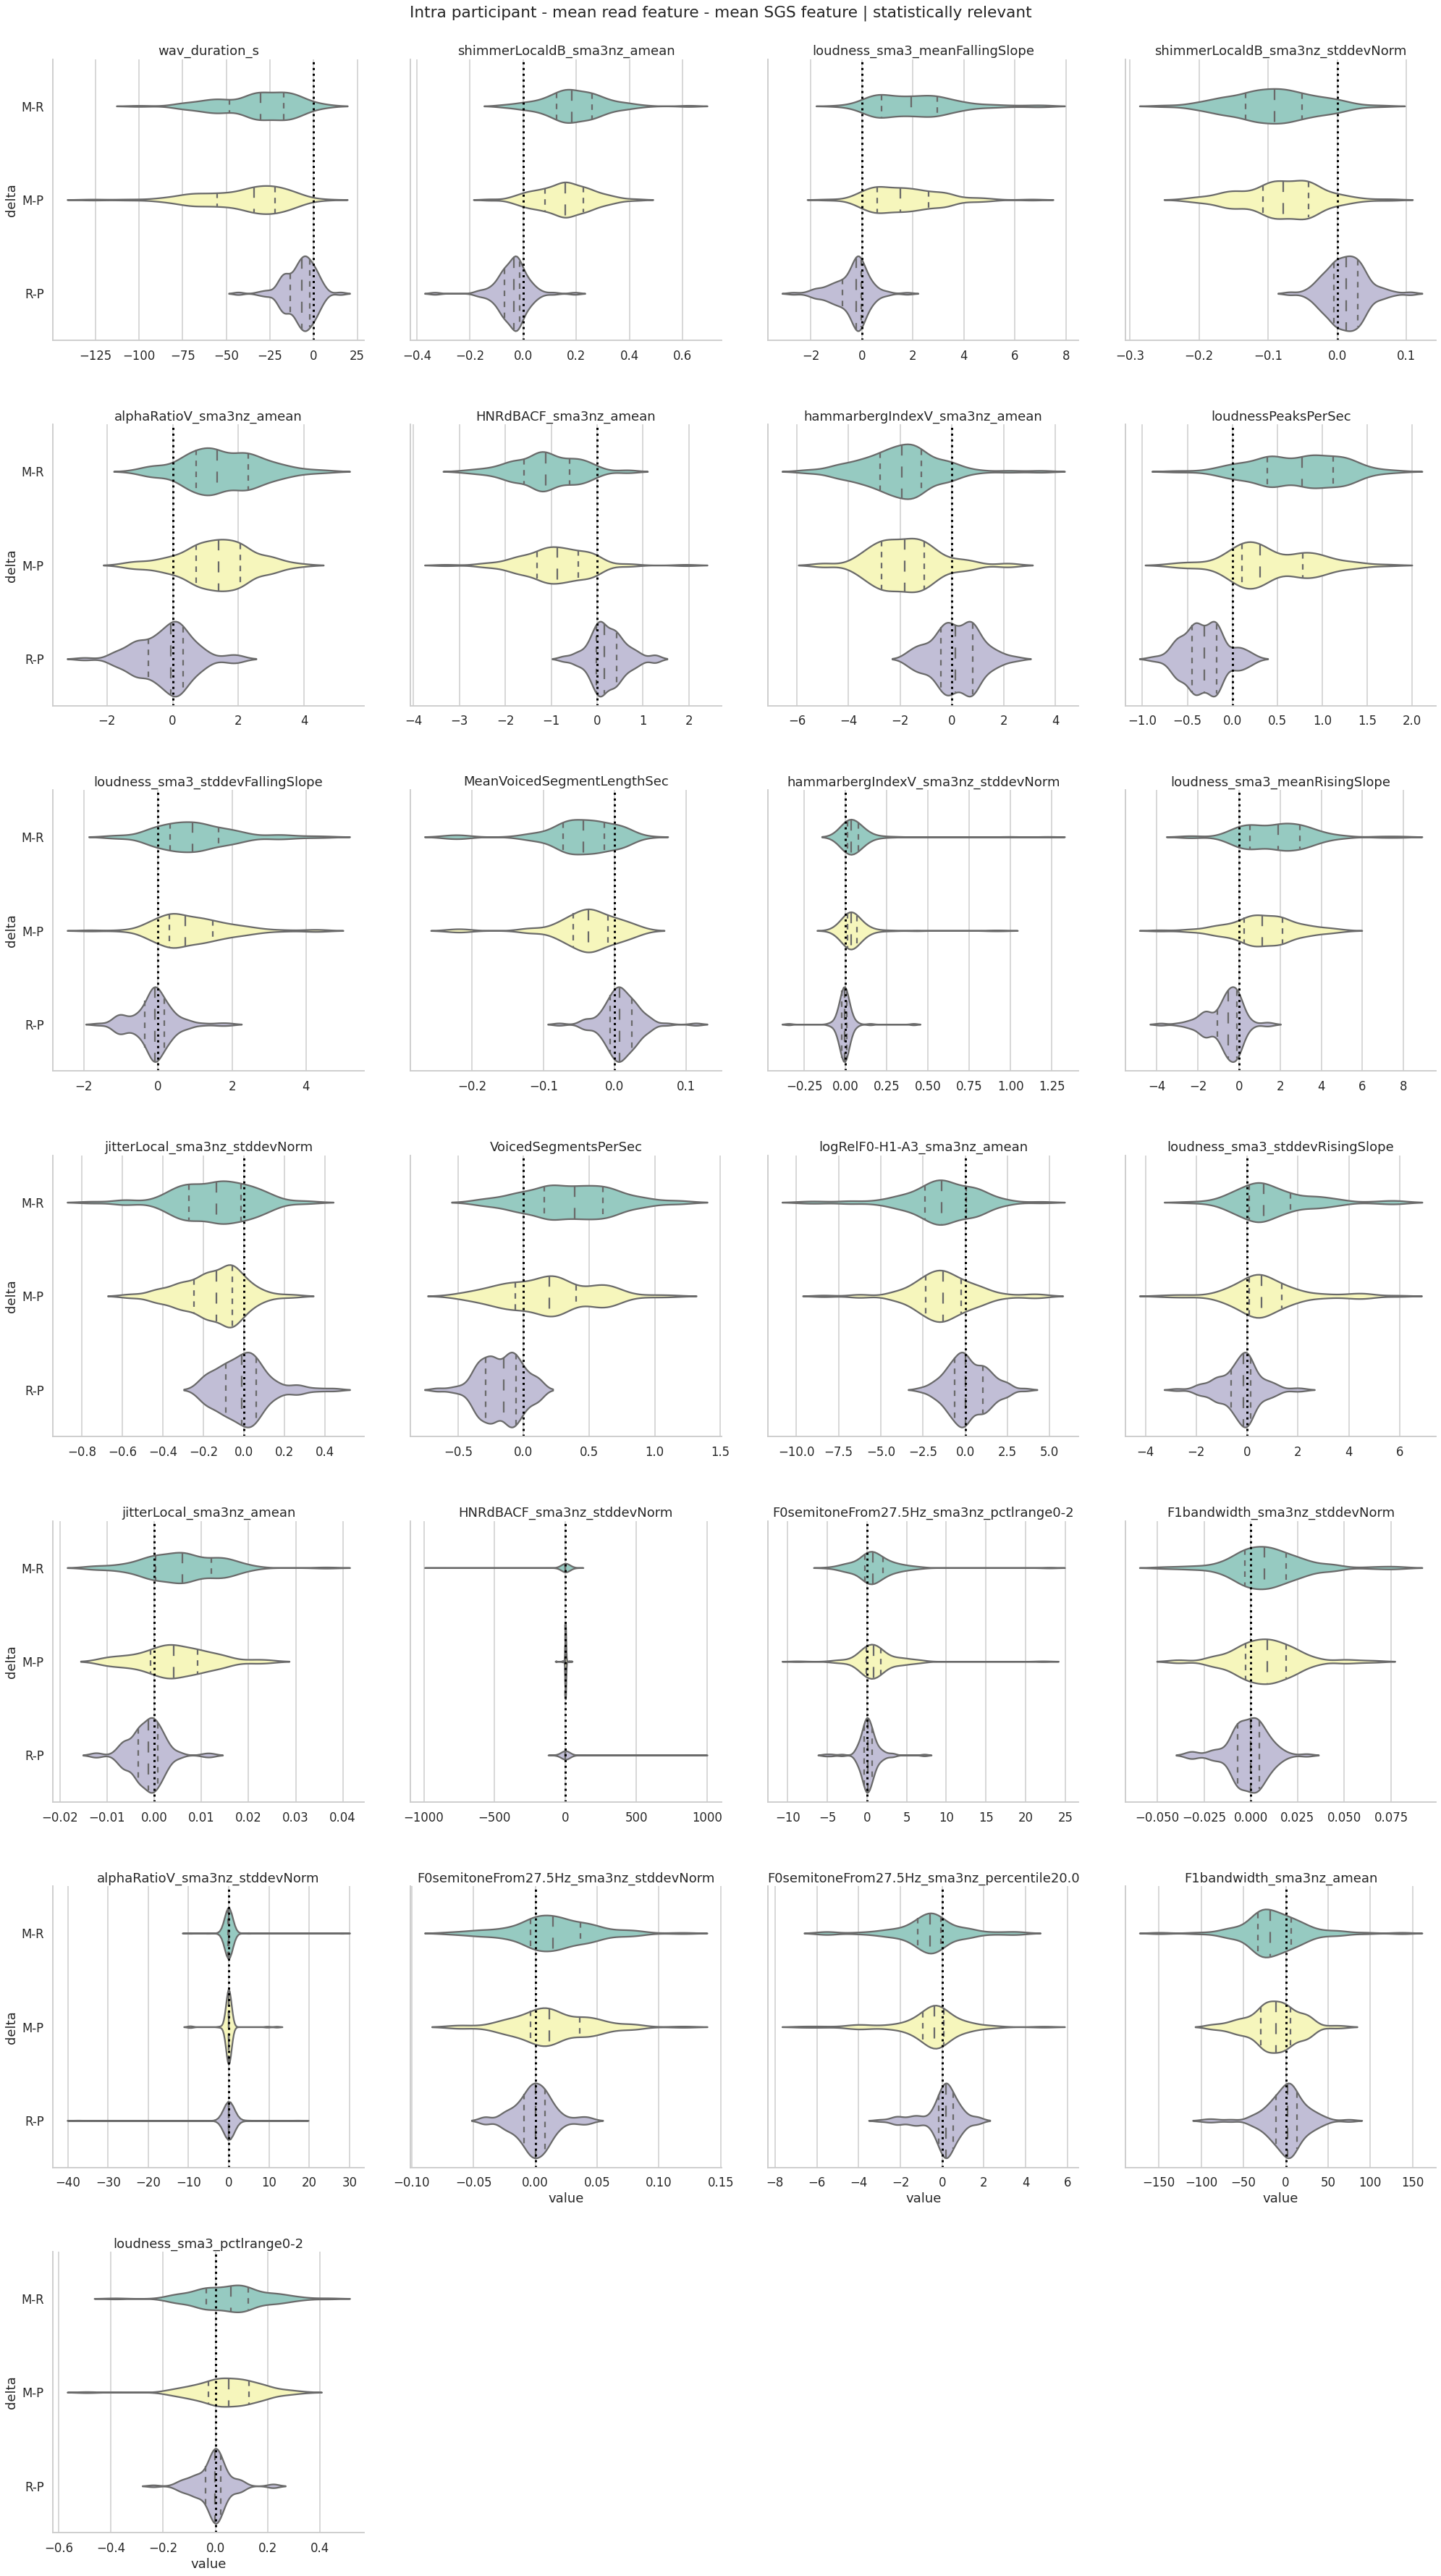

In [28]:
g = sns.catplot(
    data=mean_db_func.melt(
        id_vars=["delta"], value_vars=df_i_rel.feature.values, var_name="v"
    ),
    col="v",
    x="value",
    y="delta",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle(
    "Intra participant - mean read feature - mean SGS feature | statistically relevant",
    y=1.01,
)
g.set_titles("{col_name}")
for ax in g.fig.axes:
    ax.axvline(x=0, color="black", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)


# Generic `LLD's`

## Inter user comparison (each recording = 1 datapoint)

### Using `speech_style` statistics (read, semi-guided-speech)

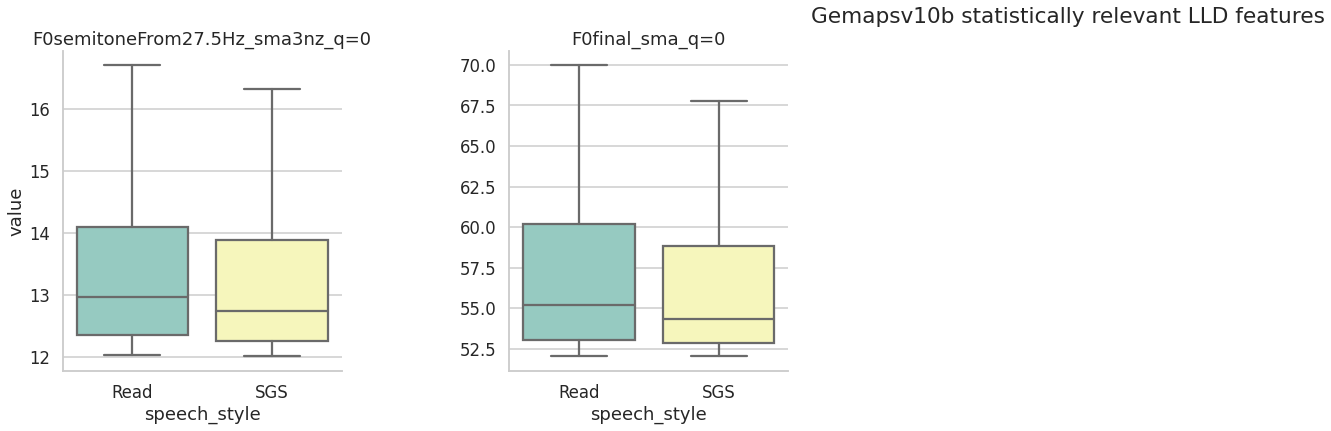

In [56]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        value_vars=df_ss_rel[
            df_ss_rel.feature.isin(
                set(df_ss_rel.feature.values).intersection(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    # + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="speech_style",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle("Gemapsv10b statistically relevant LLD features", y=1.01)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


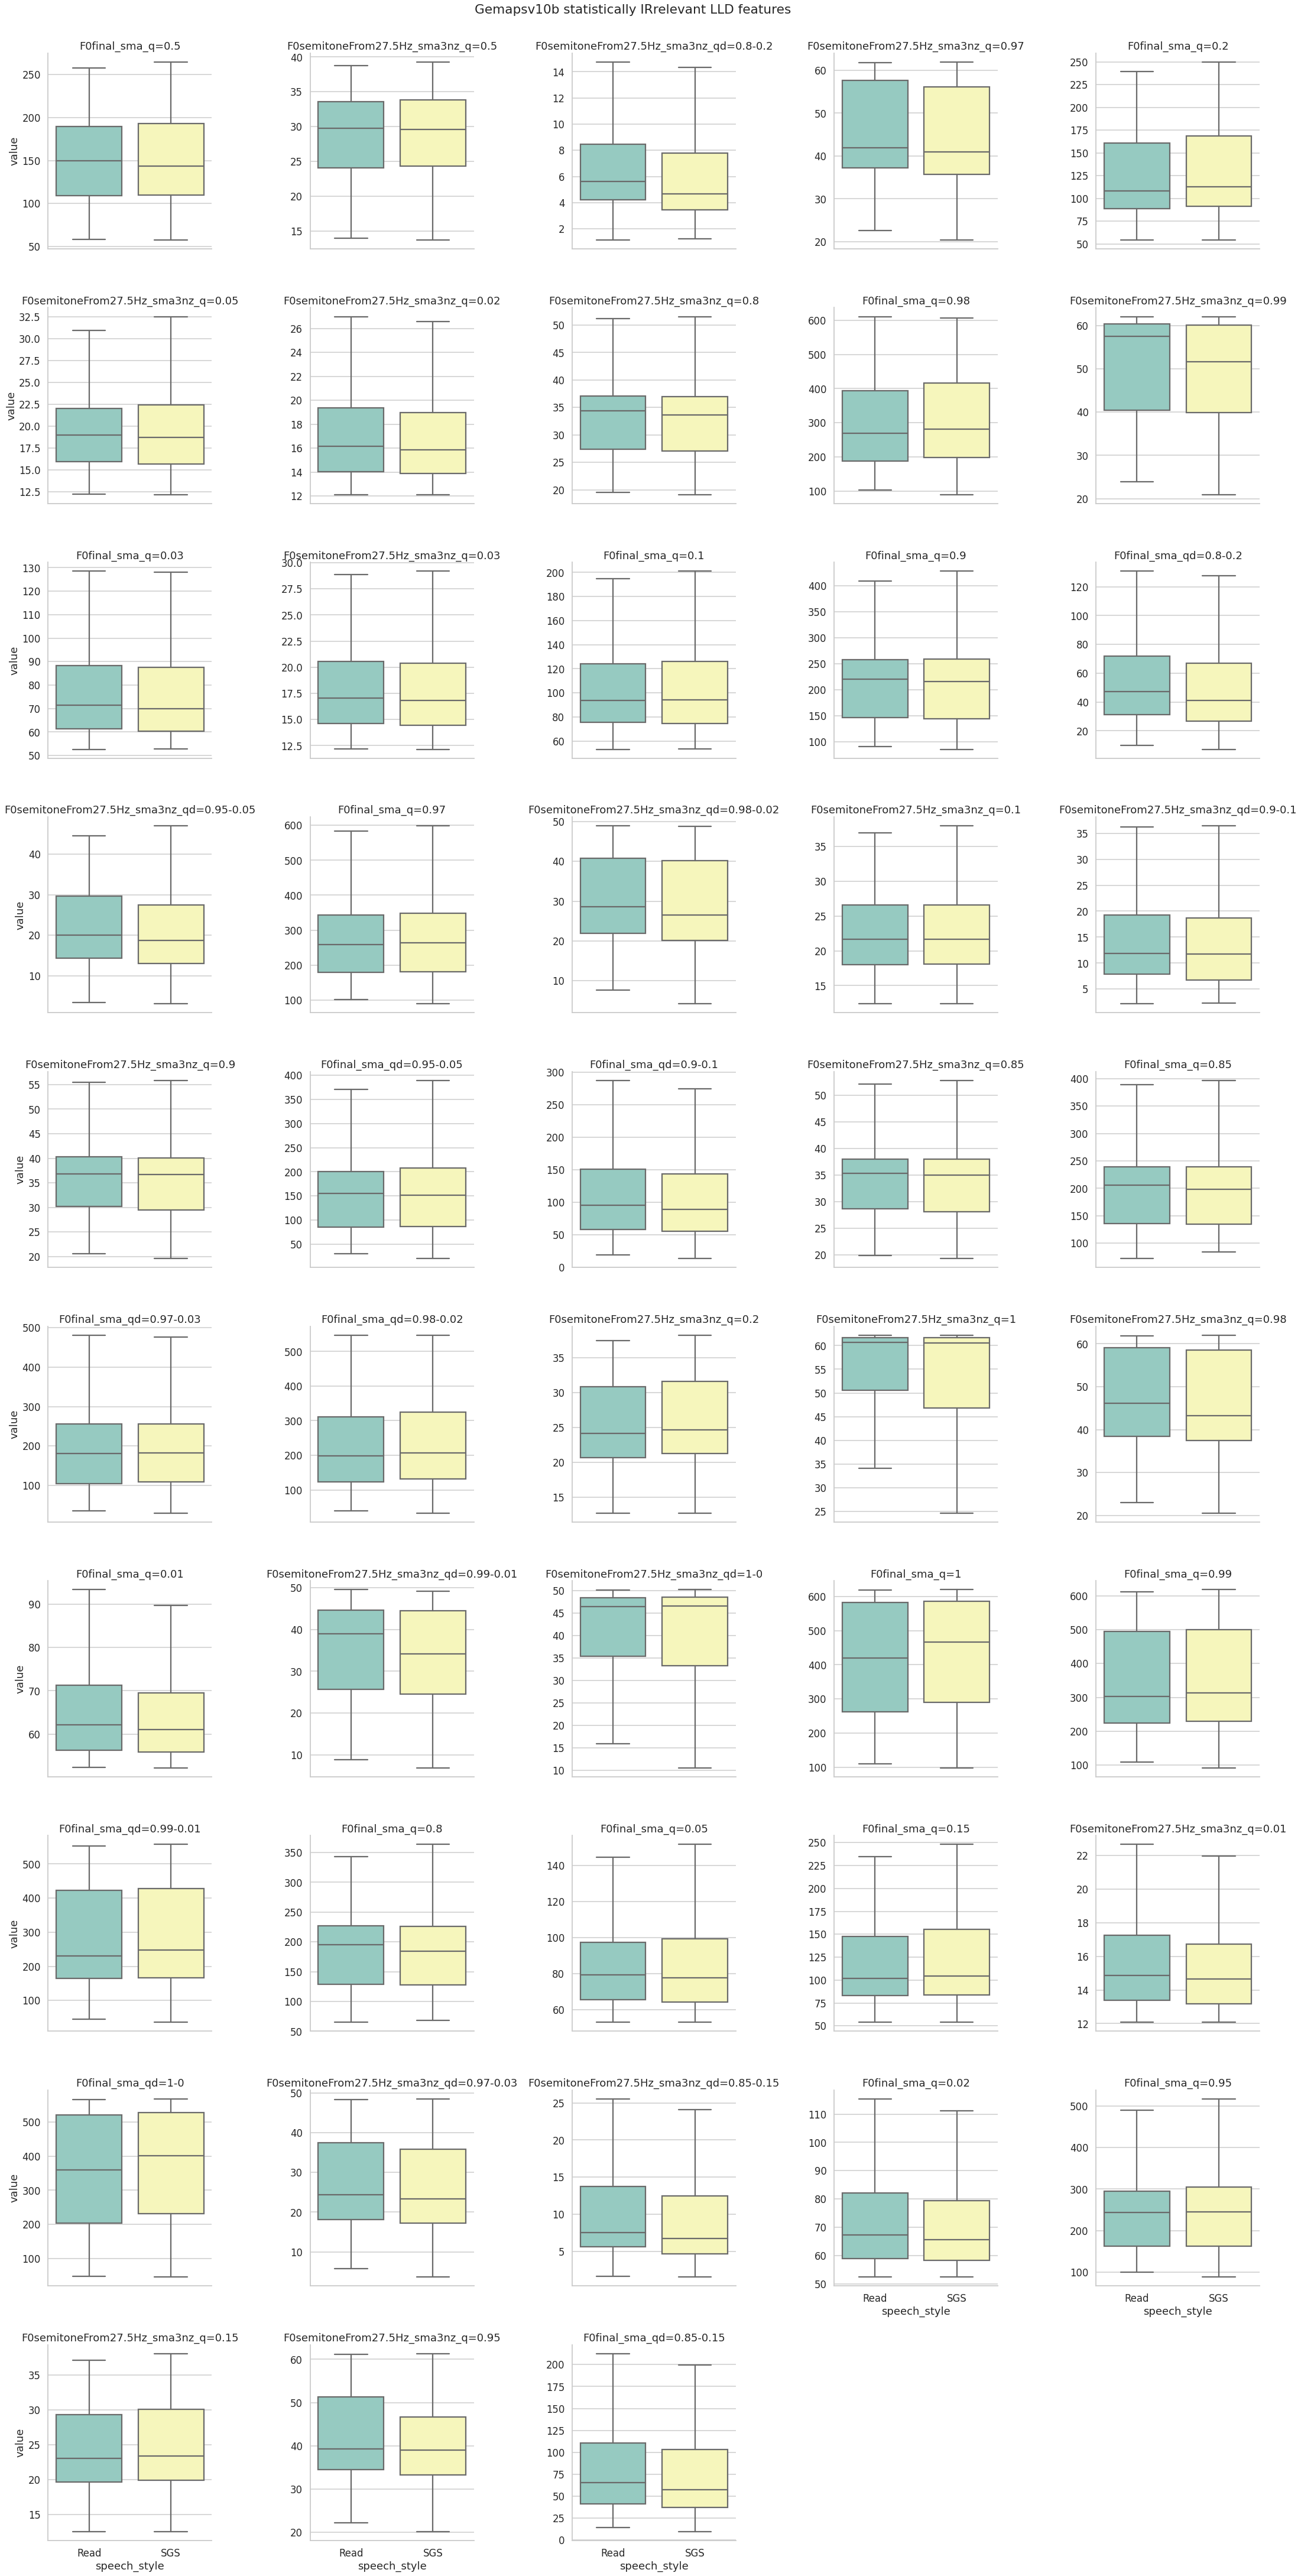

In [57]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        value_vars=set(
            list(df_session_feat.filter(like="q=").columns.values)
            + list(df_session_feat.filter(like="qd=").columns.values)
            # + list(df_session_feat.filter(like="nzcount").columns.values)
        ).difference(df_ss_rel.feature.values),
        value_name="value",
        var_name="v",
    ),
    x="speech_style",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle("Gemapsv10b statistically IRrelevant LLD features", y=1.01)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Using `database` statistics (PiSCES, Marloes)

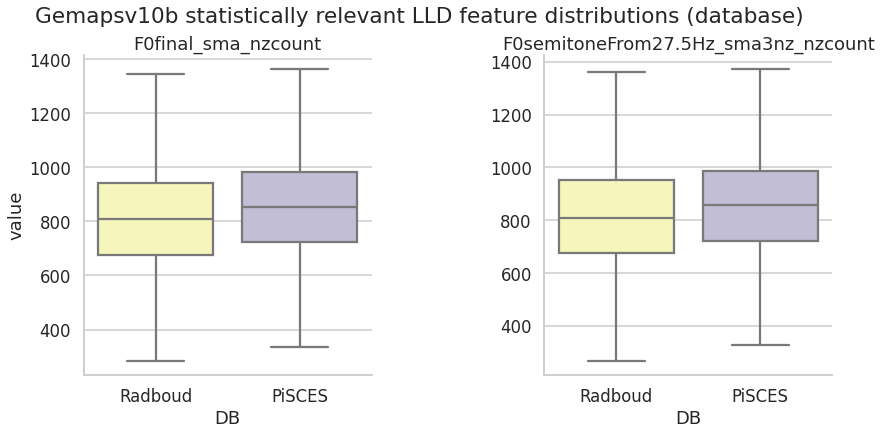

In [31]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask & (df_session.DB != "marloes")],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_db_rel[
            df_db_rel.feature.isin(
                set(df_db_rel.feature.values).intersection(
                    # also to not visualize the LLD quantile's + counts
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=2,
    height=6,
    kind="box",
    palette=sns.color_palette("Set3")[1:],
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant LLD feature distributions (database)", y=1.02
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


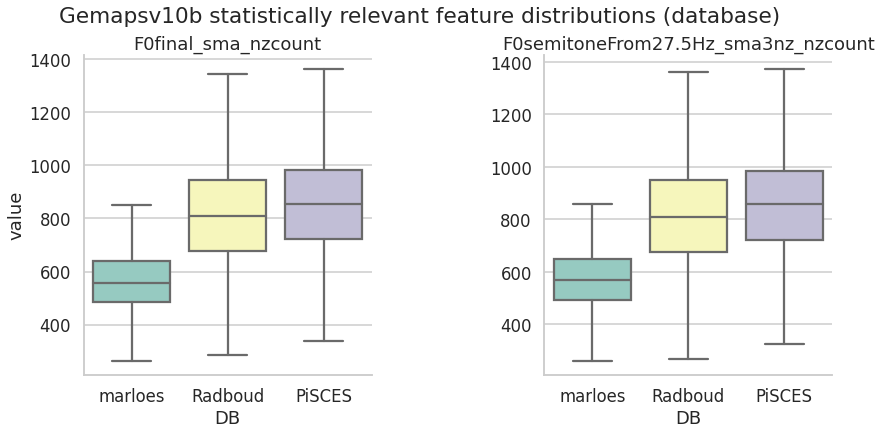

In [32]:
# same visualization as above, just added the marloes features for comparison
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_db_rel[
            df_db_rel.feature.isin(
                set(df_db_rel.feature.values).intersection(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=2,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions (database)", y=1.02
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


**insights**: Compared to the marloes values, the changes are again relatively small.

The nzcount is an own-added feature, it is a proxy for duration.

### Statistically relevant speech features for `speech_style` but not for database

In [33]:
# Features which are only statiscilly different within the `speech_type` group, but not in in the `databe` group
set(df_ss_rel.feature).difference(df_db_rel.feature).intersection(
    list(df_session_feat.filter(like="q=").columns.values)
    + list(df_session_feat.filter(like="qd=").columns.values)
    + list(df_session_feat.filter(like="nzcount").columns.values)
)


{'F0final_sma_q=0', 'F0semitoneFrom27.5Hz_sma3nz_q=0'}

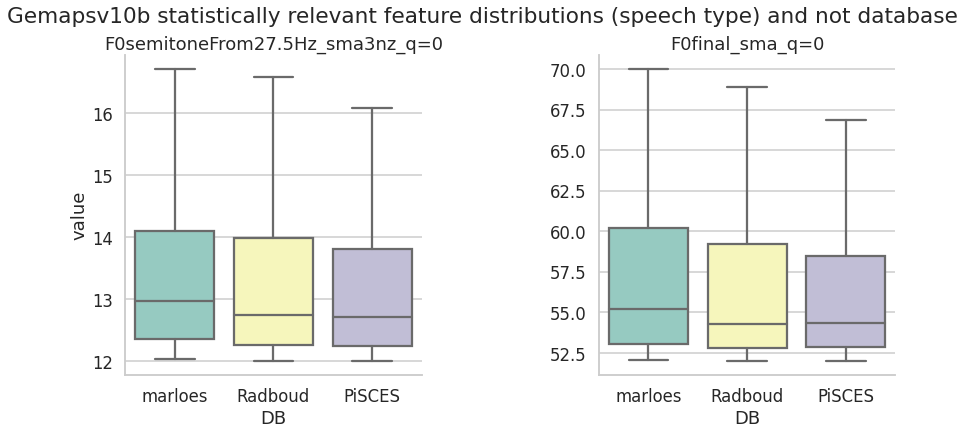

In [34]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_ss_rel[
            df_ss_rel.feature.isin(
                set(df_ss_rel.feature)
                .difference(df_db_rel.feature)
                .intersection(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=2,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions (speech type) and not database",
    y=1.02,
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Statistically relevant speech features for both `database` but not for `speech_style`

In [35]:
# Features which are only statiscilly different within the `database` group, but not in in the `speech_style` group
set(df_db_rel.feature).difference(df_ss_rel.feature).intersection(
    list(df_session_feat.filter(like="q=").columns.values)
    + list(df_session_feat.filter(like="qd=").columns.values)
    + list(df_session_feat.filter(like="nzcount").columns.values)
)


set()

## Intra user comparison: (mean) normalization per participant

In [36]:
# calculate the mean per participant, per block
# TODO -> maybe use the reference values? and subtract the control / stress block
# from these reference values
mean_func = (
    df_session_feat.groupby(["ID", "speech_style"])[
        list(set(df_session_feat.columns).difference(id_vars))
    ]
    .mean()
    .reset_index()
)

mean_sgs_func = mean_func[mean_func.speech_style == "SGS"].set_index("ID")
mean_read_func = mean_func[mean_func.speech_style == "Read"].set_index("ID")

feat_cols: List[str] = (
    list(df_session_feat.filter(like="q=").columns.values)
    # I added the nonzero count as a custom feature out of interest to see how many
    # opensmile LLD values were set to zero
    # + list(df_session_feat.filter(like="nzcount").columns.values)
)

mean_read_sgs_func = mean_read_func[feat_cols] - mean_sgs_func[feat_cols]

# ---------------------- on database level ----------------
mean_func = (
    df_session_feat[valid_mask]
    .groupby(["ID", "DB"])[list(set(df_session_feat.columns).difference(id_vars))]
    .mean()
    .reset_index()
)
mean_marloes_func = mean_func[mean_func.DB == "marloes"].set_index("ID")
mean_radboud_func = mean_func[mean_func.DB == "Radboud"].set_index("ID")
mean_pisces_func = mean_func[mean_func.DB == "PiSCES"].set_index("ID")

mean_db_func = [
    (mean_marloes_func[feat_cols] - mean_radboud_func[feat_cols]).assign(delta="M-R")
]
mean_db_func.append(
    (mean_marloes_func[feat_cols] - mean_pisces_func[feat_cols]).assign(delta="M-P")
)
mean_db_func.append(
    (mean_radboud_func[feat_cols] - mean_pisces_func[feat_cols]).assign(delta="R-P")
)
mean_db_func = pd.concat(mean_db_func)


In [37]:
from scipy.stats import wilcoxon

feat_score_list = []
for feat in mean_read_sgs_func.columns:
    test = wilcoxon(
        x=mean_read_sgs_func[feat].values, alternative="two-sided", nan_policy="omit"
    )
    feat_score_list.append([feat, test.pvalue])

df_i = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_i_rel = df_i[df_i.p_value < 0.001]
df_i_rel_05 = df_i[df_i.p_value < 0.05]


In [38]:
df_i_rel


feature   p_value
24                   F0final_sma_q=0.2  0.000004
7    F0semitoneFrom27.5Hz_sma3nz_q=0.2  0.000018
23                  F0final_sma_q=0.15  0.000203
6   F0semitoneFrom27.5Hz_sma3nz_q=0.15  0.000845

### `speech_style`: sgs vs. read

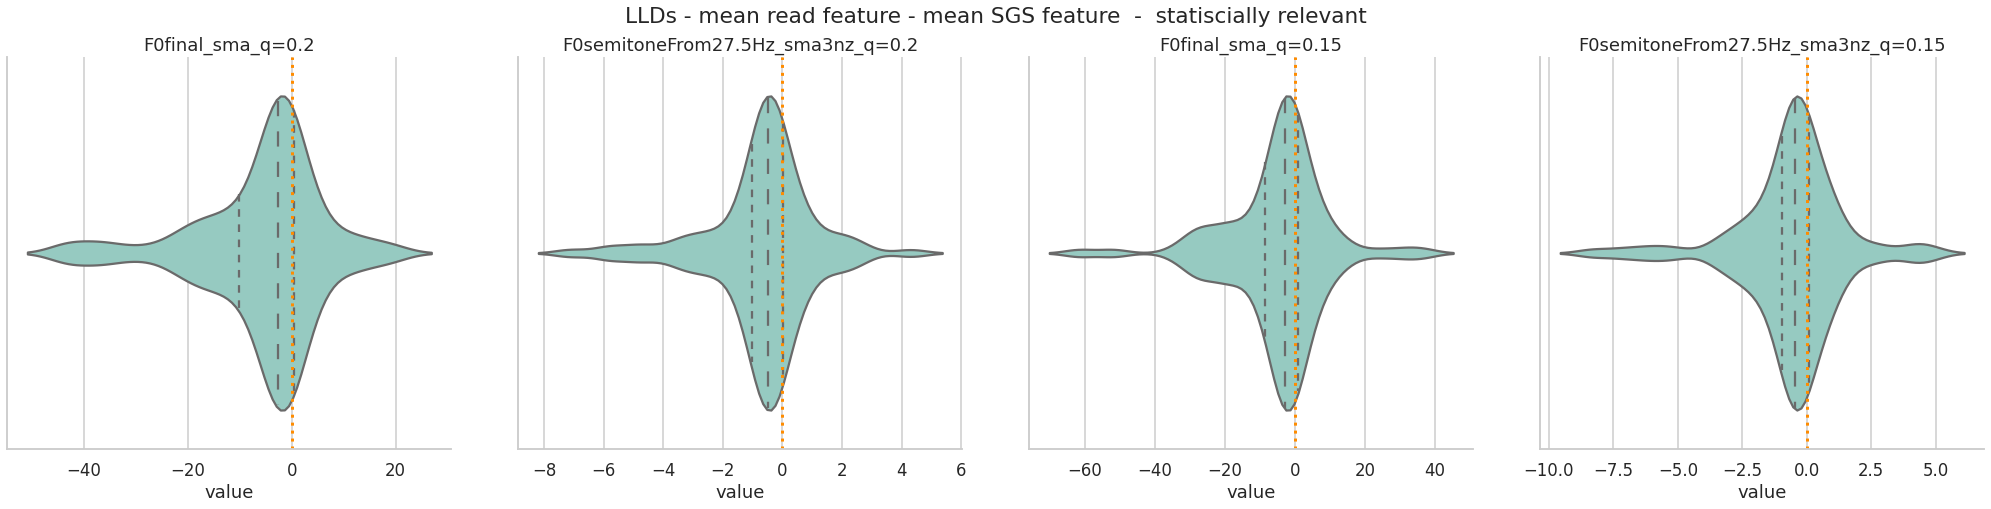

In [39]:
g = sns.catplot(
    data=mean_read_sgs_func[df_i_rel.feature.values].melt(var_name="v"),
    col="v",
    x="value",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle(
    "LLDs - mean read feature - mean SGS feature  -  statiscially relevant", y=1.02
)
g.set_titles("{col_name}")
for ax in g.fig.axes:
    ax.axvline(x=0, color="darkorange", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)


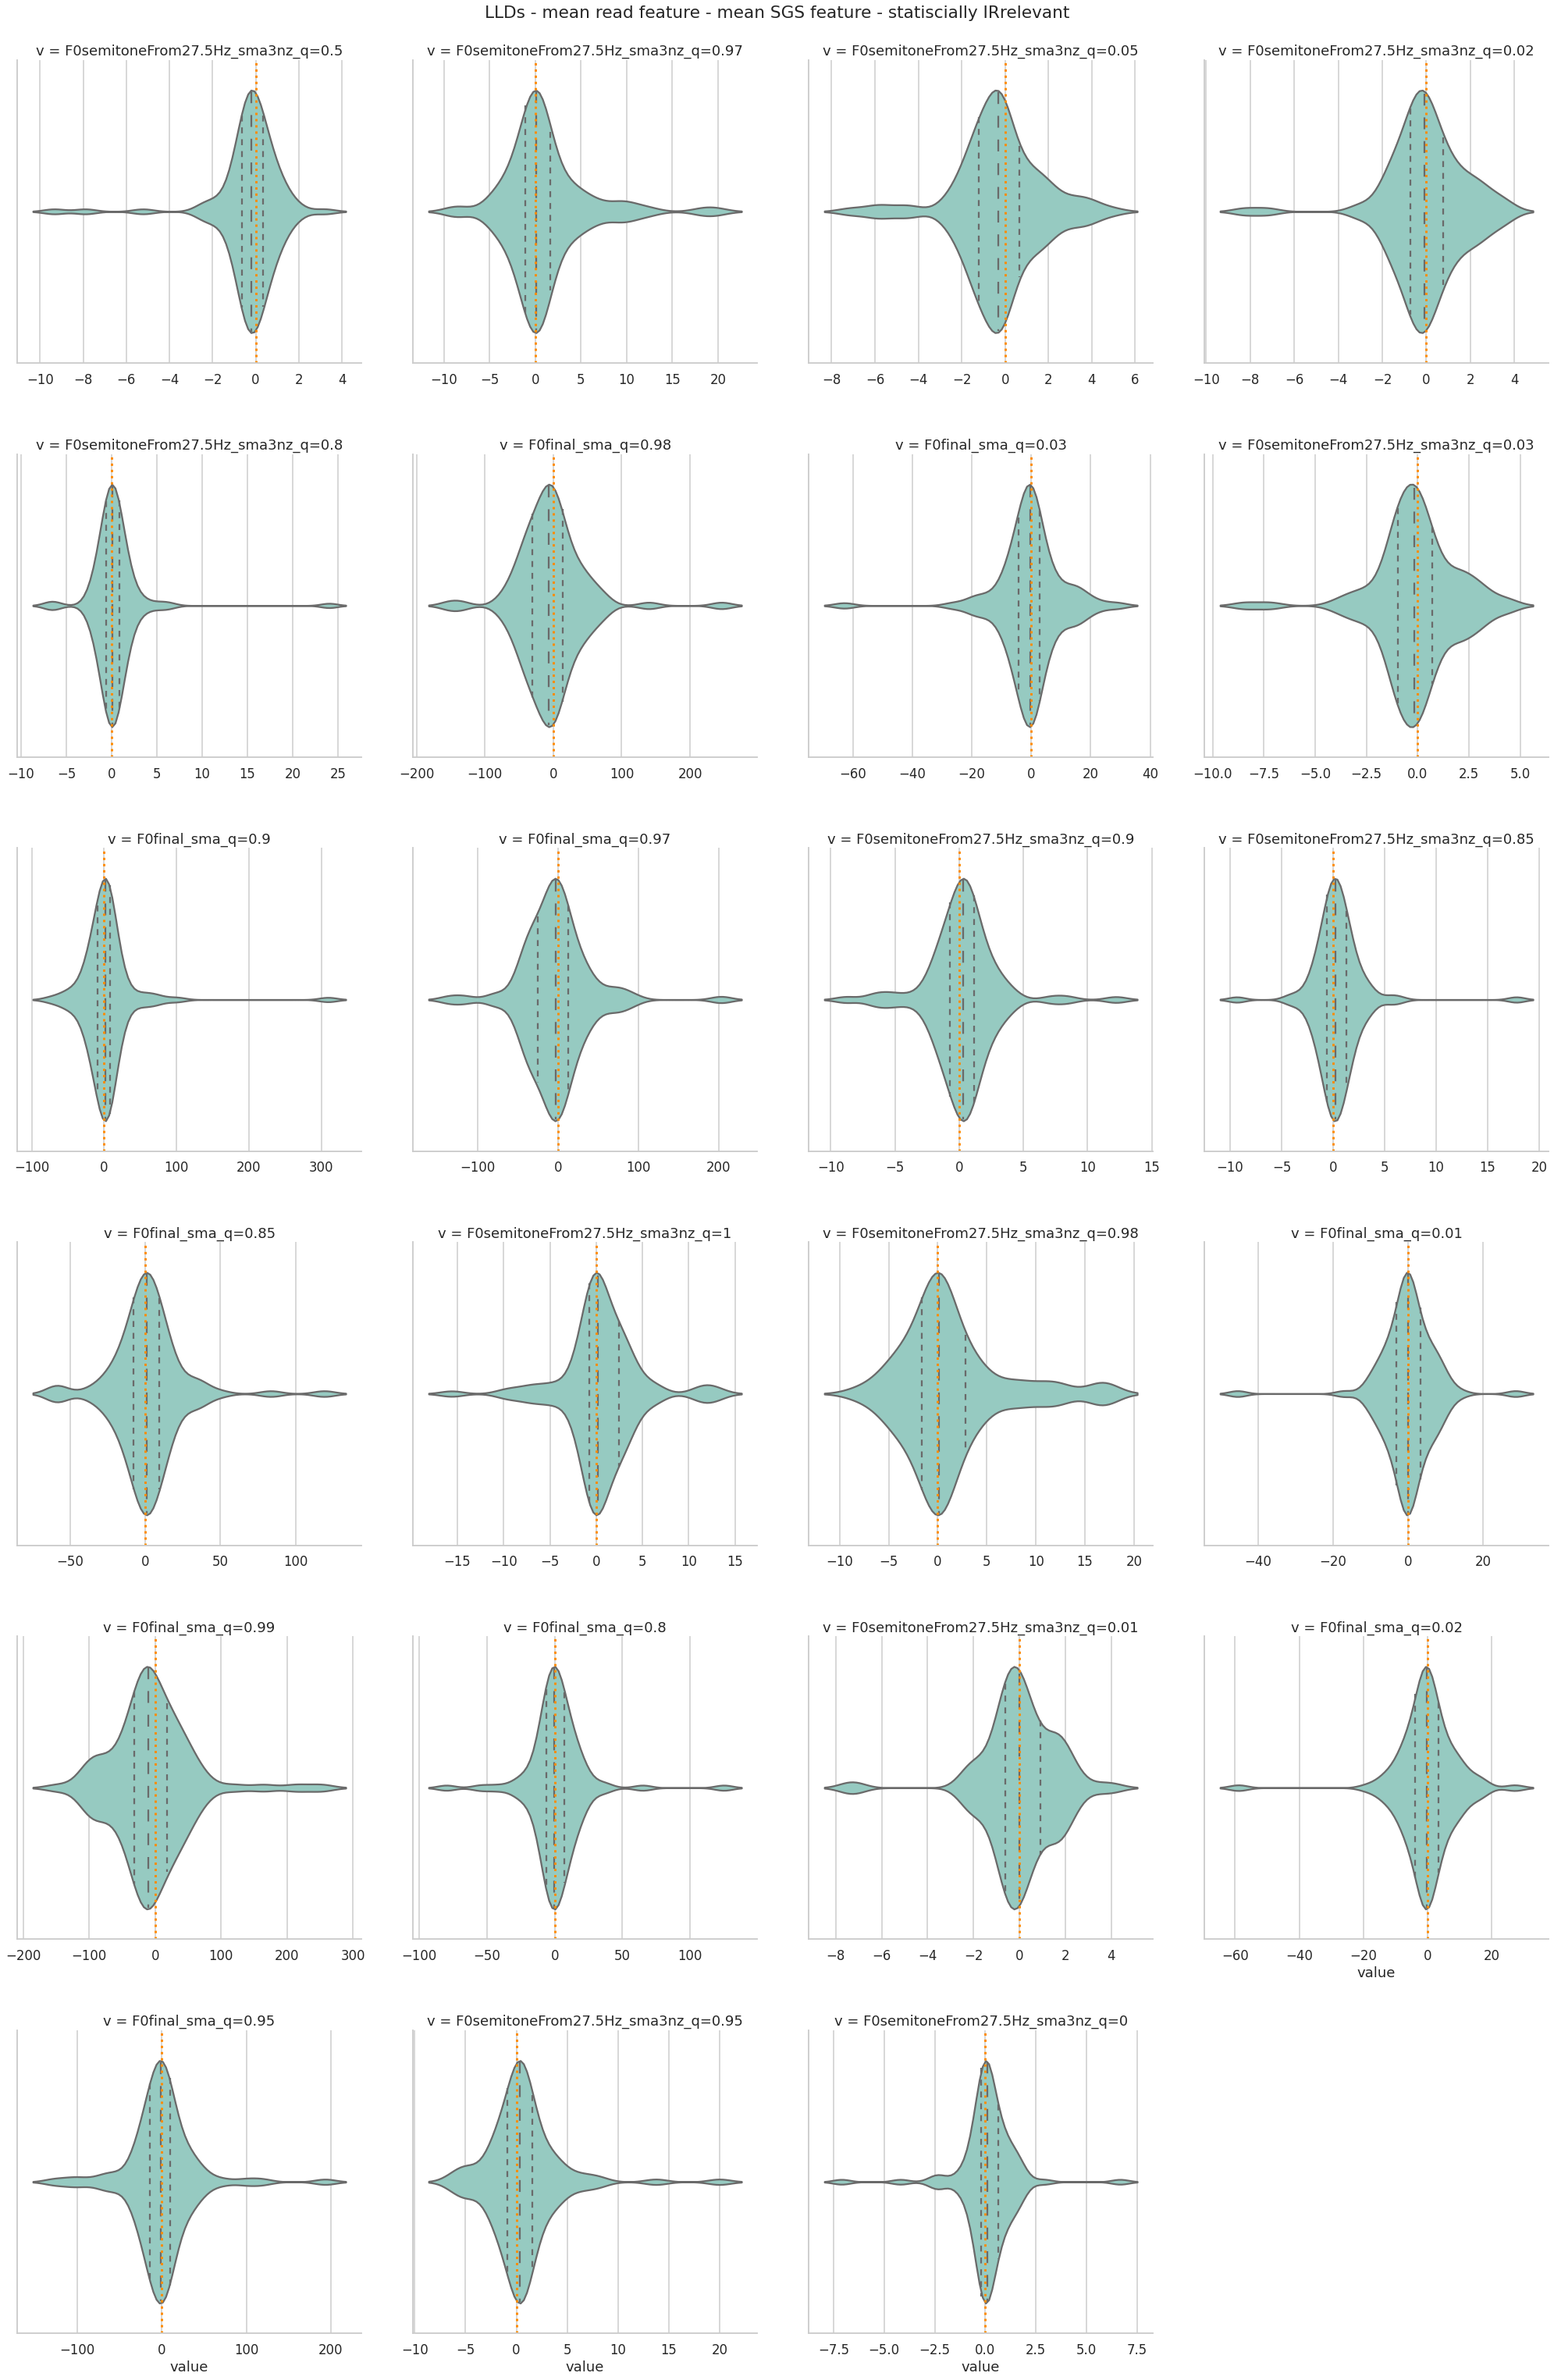

In [40]:
g = sns.catplot(
    data=mean_read_sgs_func[
        list(set(mean_read_sgs_func.columns).difference(df_i_rel_05.feature.values))
    ]
    .iloc[:, :]
    .melt(var_name="v"),
    col="v",
    x="value",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle(
    "LLDs - mean read feature - mean SGS feature - statiscially IRrelevant", y=1.01
)
for ax in g.fig.axes:
    ax.axvline(x=0, color="darkorange", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)


### `database` deltas **(beautiful figure!)**

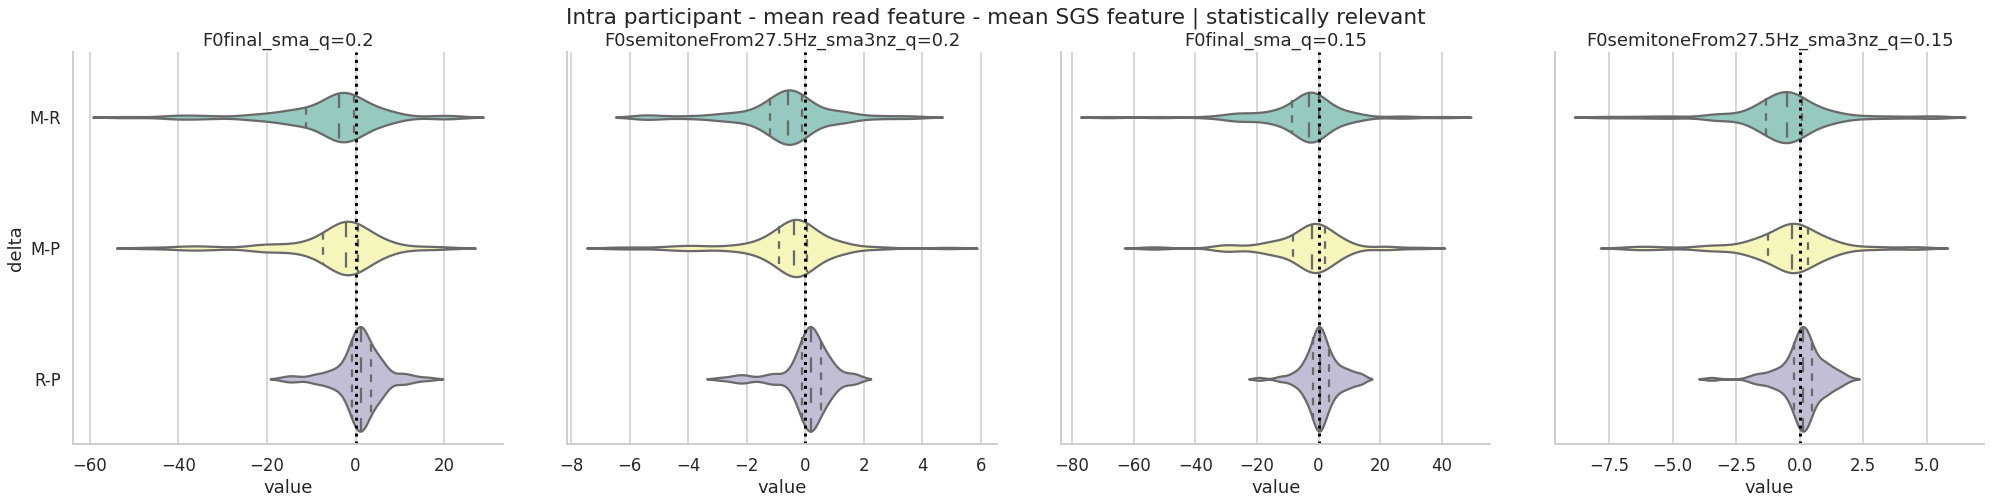

In [41]:
g = sns.catplot(
    data=mean_db_func.melt(
        id_vars=["delta"], value_vars=df_i_rel.feature.values, var_name="v"
    ),
    col="v",
    x="value",
    y="delta",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle(
    "Intra participant - mean read feature - mean SGS feature | statistically relevant",
    y=1.01,
)
g.set_titles("{col_name}")
for ax in g.fig.axes:
    ax.axvline(x=0, color="black", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)


# F0-range

In [42]:
qs = sum([[1 - q, q] for q in [0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2]], [])
q_med = [0.5]


In [43]:
for sig in ["F0final_sma", "F0semitoneFrom27.5Hz_sma3nz"]:
    for (max_q, min_q) in list(zip(qs[::2], qs[1::2])):
        max_q_col = "_".join([sig, f"q={max_q}"])
        min_q_col = "_".join([sig, f"q={min_q}"])

        df_session_feat[f"{sig}_qd={max_q}-{min_q}"] = (
            df_session_feat[max_q_col] - df_session_feat[min_q_col]
        )


## Statistics

In [44]:
feat_score_list = []
for feature in set(df_session_feat.filter(like="_qd=").columns):
    # print(feature)
    test = mannwhitneyu(
        df_session_feat[(df_session_feat.speech_style == "Read") & valid_mask][feature],
        df_session_feat[(df_session_feat.speech_style == "SGS") & valid_mask][feature],
        alternative="two-sided",
        nan_policy="omit",
    )
    feat_score_list.append([feature, test.pvalue])

df_ss_qd = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_ss_qd_rel = df_ss_qd[df_ss_qd.p_value < 0.001]
df_ss_qd_rel_05 = df_ss_qd[df_ss_qd.p_value < 0.05]


feat_score_list = []
for feature in set(df_session_feat.filter(like="_qd=").columns):
    # print(feature)
    test = mannwhitneyu(
        df_session_feat[(df_session_feat.DB == "PiSCES") & valid_mask][feature],
        df_session_feat[(df_session_feat.DB == "Radboud") & valid_mask][feature],
        alternative="two-sided",
        nan_policy="omit",
    )
    feat_score_list.append([feature, test.pvalue])

df_db_qd = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_db_qd_rel = df_db_qd[df_db_qd.p_value < 0.001]
df_db_qd_rel_05 = df_db_qd[df_db_qd.p_value < 0.05]

del feat_score_list, test


## Inter-user comparison (each recording = 1 datapoint)

### using `speech_style` statistics (read, semi-guided-speech)

In [45]:
df_ss_qd_rel


feature       p_value
7     F0semitoneFrom27.5Hz_sma3nz_qd=0.8-0.2  1.221563e-12
0                     F0final_sma_qd=0.8-0.2  8.764676e-07
6   F0semitoneFrom27.5Hz_sma3nz_qd=0.85-0.15  1.122485e-06
12                  F0final_sma_qd=0.85-0.15  8.576010e-04

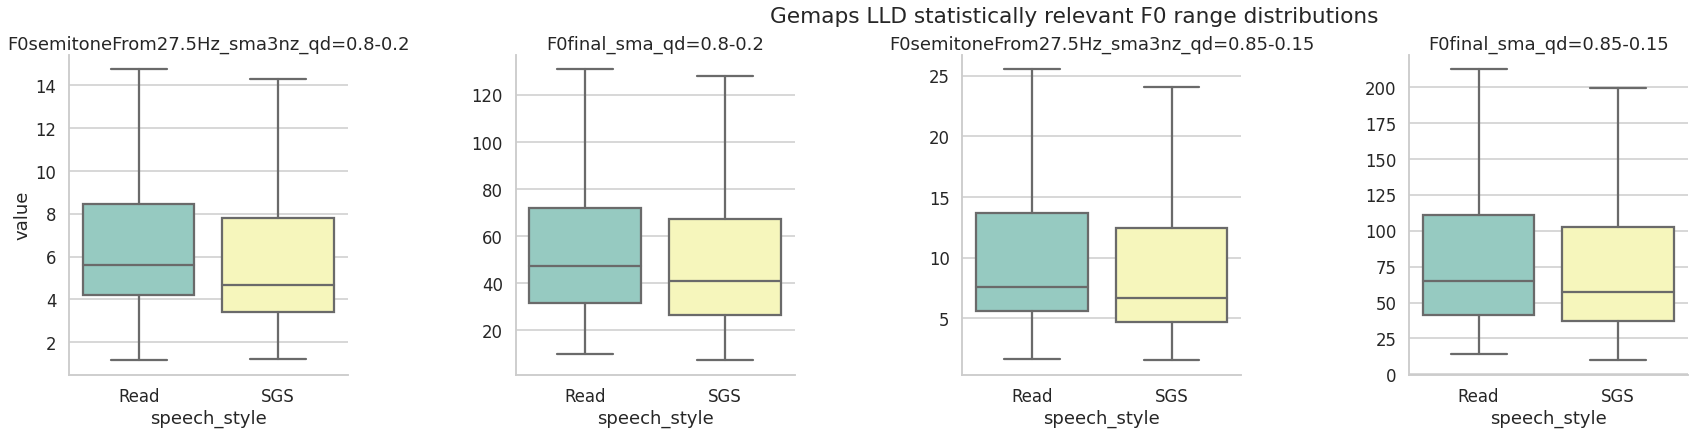

In [46]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        value_vars=df_ss_qd_rel[
            df_ss_qd_rel.feature.isin(
                set(df_ss_qd_rel.feature.values).intersection(
                    df_session_feat.filter(like="qd=").columns.values
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="speech_style",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle("Gemaps LLD statistically relevant F0 range distributions", y=1.02)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


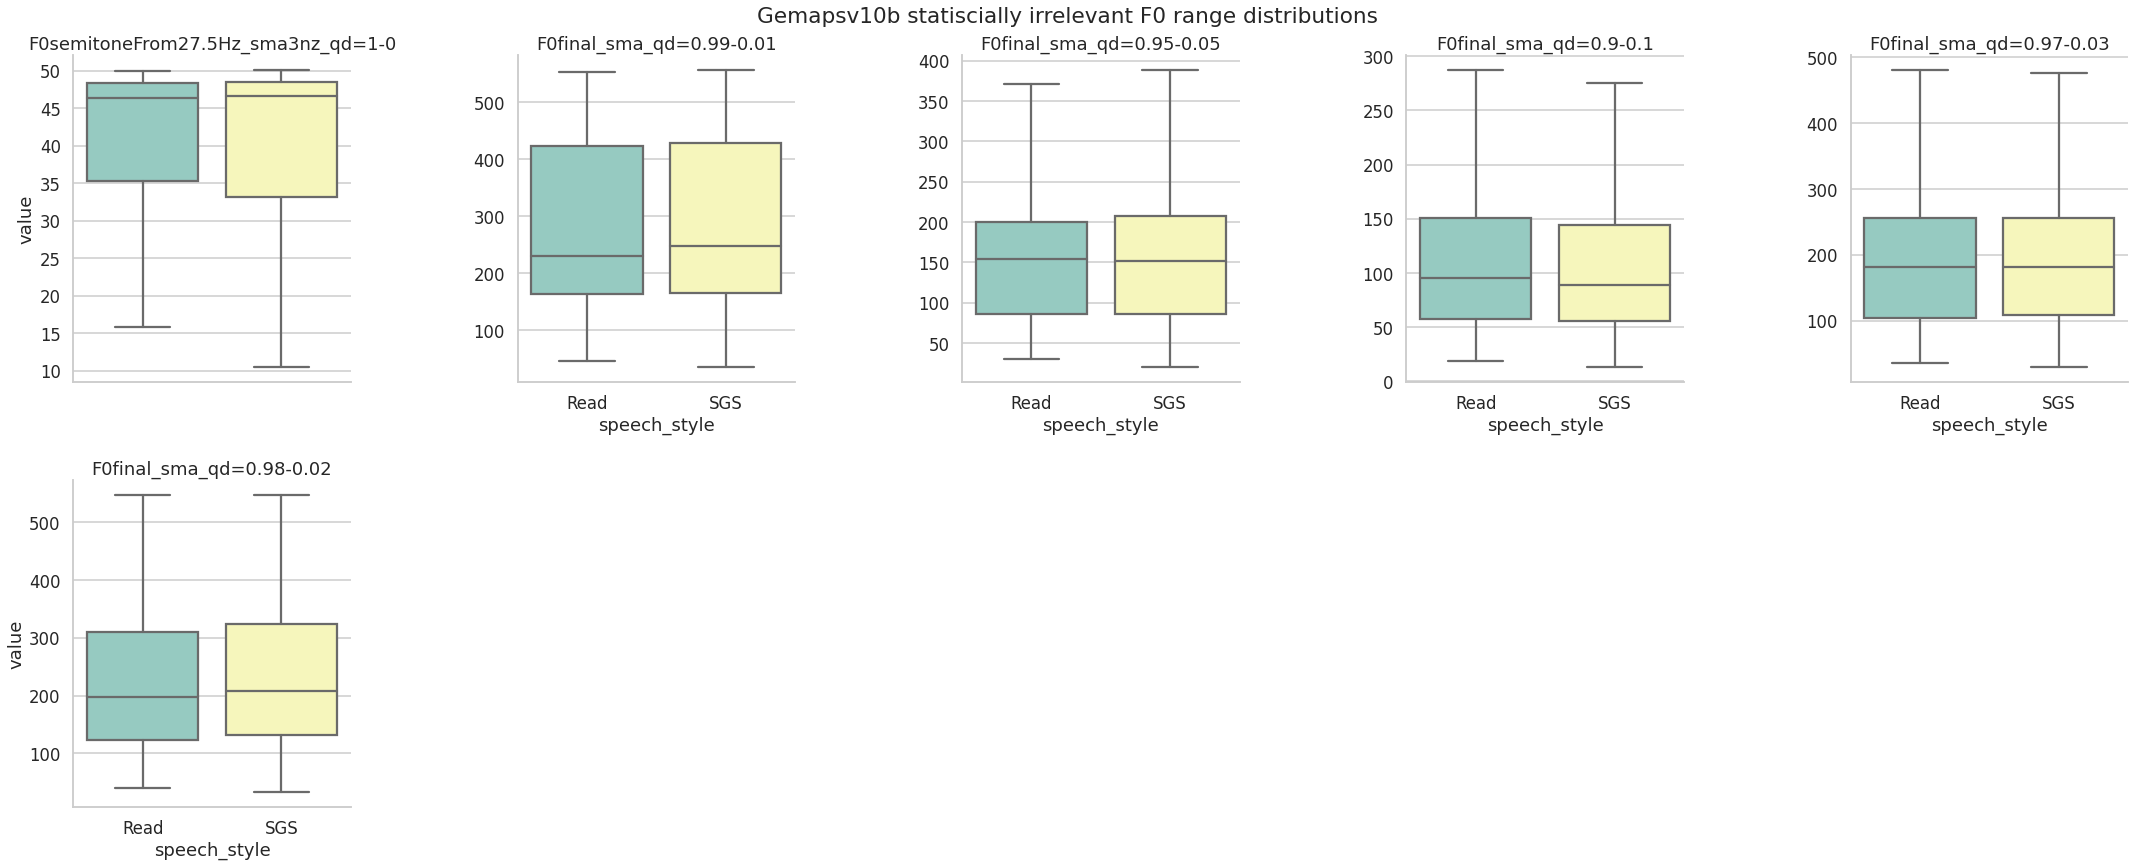

In [47]:
sns.set_context("talk")
sns.set_style("whitegrid")
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # Note: this way
        value_vars=set(df_session_feat.filter(like="qd=").columns.values).difference(
            df_ss_qd_rel_05.feature.values
        ),
        value_name="value",
        var_name="v",
    ),
    x="speech_style",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle("Gemapsv10b statiscially irrelevant F0 range distributions", y=1.01)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)
box_ylims = [ax.get_ylim() for ax in g.axes.flat]


### Using `database` statistics (PiSCES, Marloes)

In [48]:
df_db_qd_rel


Empty DataFrame
Columns: [feature, p_value]
Index: []

In [49]:
df_db_qd


feature   p_value
3                         F0final_sma_qd=1-0  0.028930
8         F0semitoneFrom27.5Hz_sma3nz_qd=1-0  0.097591
0                     F0final_sma_qd=0.8-0.2  0.101115
7     F0semitoneFrom27.5Hz_sma3nz_qd=0.8-0.2  0.178968
12                  F0final_sma_qd=0.85-0.15  0.261021
6   F0semitoneFrom27.5Hz_sma3nz_qd=0.85-0.15  0.323659
9     F0semitoneFrom27.5Hz_sma3nz_qd=0.9-0.1  0.338399
10                  F0final_sma_qd=0.95-0.05  0.359556
11                    F0final_sma_qd=0.9-0.1  0.377792
1   F0semitoneFrom27.5Hz_sma3nz_qd=0.95-0.05  0.424494
14                  F0final_sma_qd=0.97-0.03  0.573449
2   F0semitoneFrom27.5Hz_sma3nz_qd=0.98-0.02  0.595934
4   F0semitoneFrom27.5Hz_sma3nz_qd=0.99-0.01  0.612487
5   F0semitoneFrom27.5Hz_sma3nz_qd=0.97-0.03  0.712310
13                  F0final_sma_qd=0.99-0.01  0.916358
15                  F0final_sma_qd=0.98-0.02  0.950861

Aha, all *pvalue*s are too high; no significant changes :)

### Statistically relevant features for `speech_style`, but not for database group

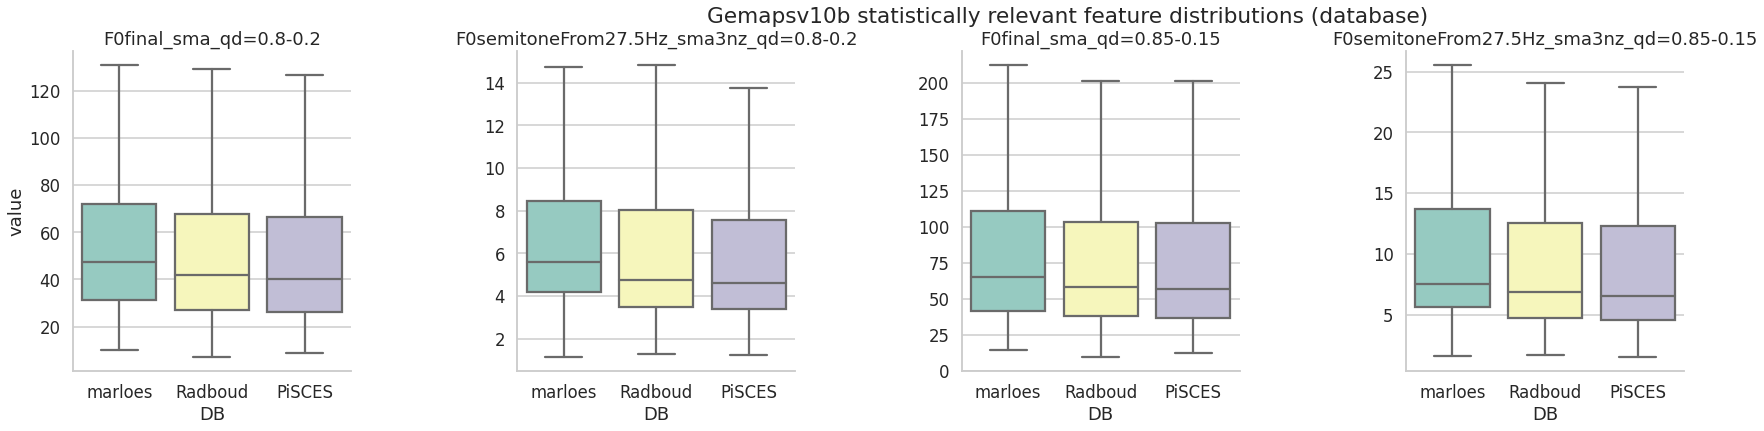

In [50]:
# same visualization as above, just added the marloes features for comparison
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=set(df_ss_qd_rel.feature.values).difference(df_db_qd_rel),
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions (database)", y=1.01
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


## Intra participant comparison: (mean) normalization per participant

In [51]:
# calculate the mean per participant, per block
# TODO -> maybe use the reference values? and subtract the control / stress block
# from these reference values

# --------------- on speech_style level ----------------
mean_func = (
    df_session_feat[valid_mask]
    .groupby(["ID", "speech_style"])[
        list(set(df_session_feat.columns).difference(id_vars))
    ]
    .mean()
    .reset_index()
)

mean_sgs_func = mean_func[mean_func.speech_style == "SGS"].set_index("ID")
mean_read_func = mean_func[mean_func.speech_style == "Read"].set_index("ID")

feat_cols: List[str] = list(df_session_feat.filter(like="qd=").columns.values)

mean_read_sgs_func = mean_read_func[feat_cols] - mean_sgs_func[feat_cols]


# ---------------------- on database level ----------------
mean_func = (
    df_session_feat[valid_mask]
    .groupby(["ID", "DB"])[list(set(df_session_feat.columns).difference(id_vars))]
    .mean()
    .reset_index()
)
mean_marloes_func = mean_func[mean_func.DB == "marloes"].set_index("ID")
mean_radboud_func = mean_func[mean_func.DB == "Radboud"].set_index("ID")
mean_pisces_func = mean_func[mean_func.DB == "PiSCES"].set_index("ID")

mean_db_func = [
    (mean_marloes_func[feat_cols] - mean_radboud_func[feat_cols]).assign(delta="M-R")
]
mean_db_func.append(
    (mean_marloes_func[feat_cols] - mean_pisces_func[feat_cols]).assign(delta="M-P")
)
mean_db_func.append(
    (mean_radboud_func[feat_cols] - mean_pisces_func[feat_cols]).assign(delta="R-P")
)
mean_db_func = pd.concat(mean_db_func)


In [52]:
from scipy.stats import wilcoxon

feat_score_list = []
for feat in mean_read_sgs_func.columns:
    test = wilcoxon(
        x=mean_read_sgs_func[feat].values, alternative="two-sided", nan_policy="omit"
    )
    feat_score_list.append([feat, test.pvalue])

df_i = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_i_rel = df_i[df_i.p_value < 0.001]
df_i_rel_05 = df_i[df_i.p_value < 0.05]


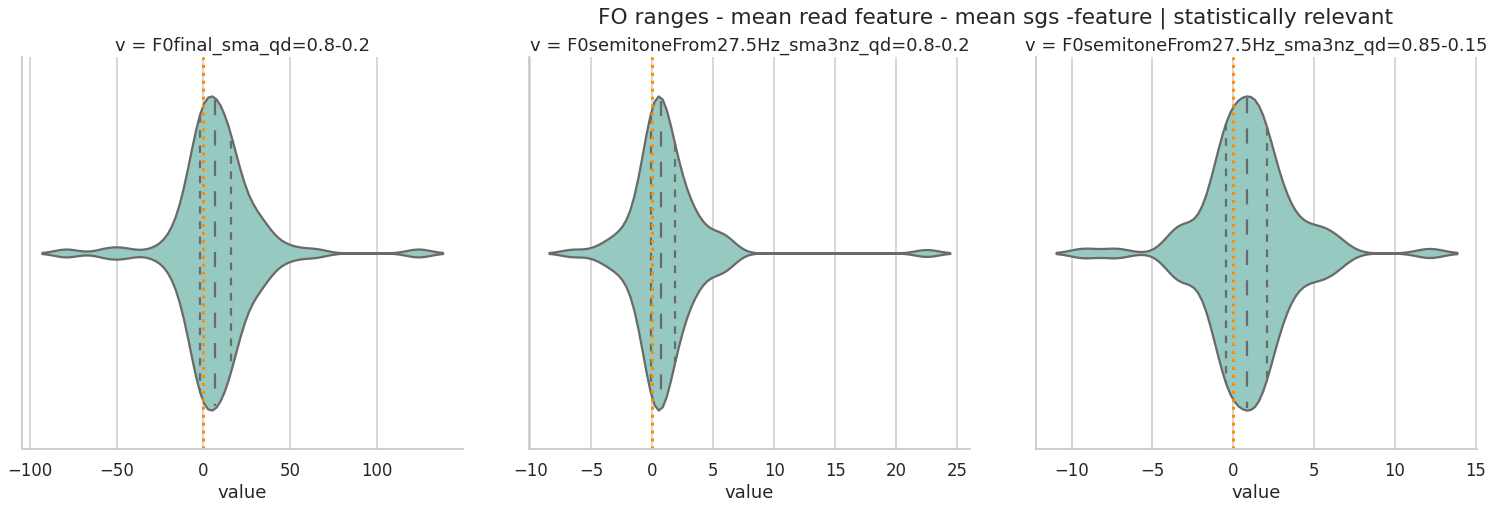

In [54]:
g = sns.catplot(
    data=mean_read_sgs_func[df_i_rel.feature.values].melt(var_name="v"),
    col="v",
    x="value",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle(
    "FO ranges - mean read feature - mean sgs -feature | statistically relevant", y=1.02
)
for ax in g.fig.axes:
    ax.axvline(x=0, color="darkorange", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)


### `database` delta's **! beautiful figure**

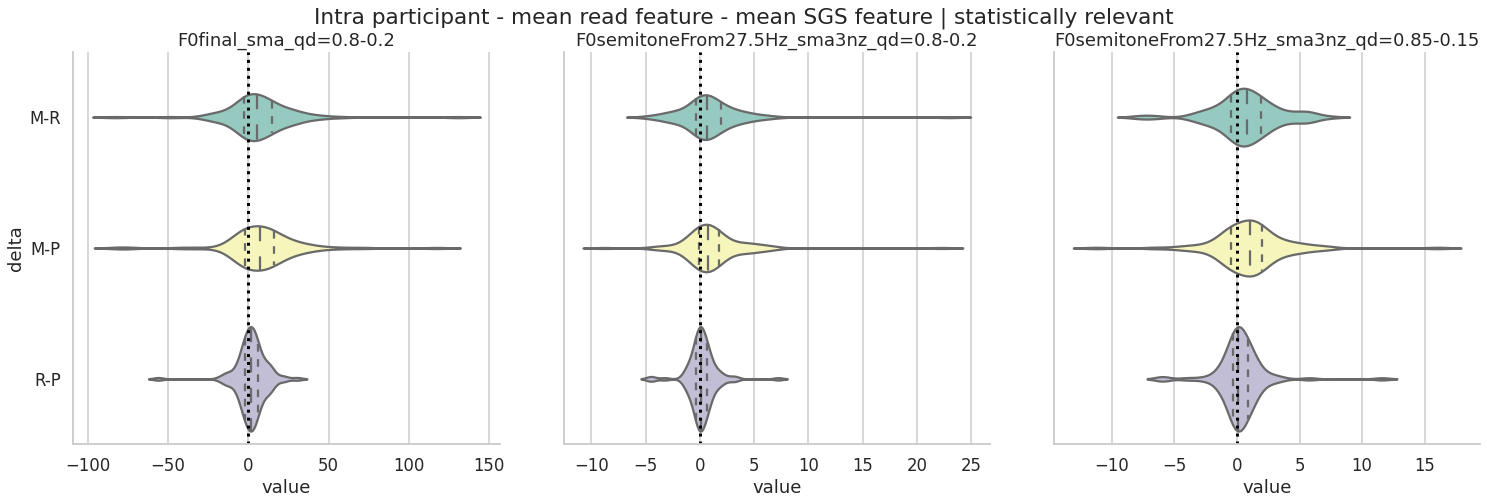

In [58]:
g = sns.catplot(
    data=mean_db_func.melt(
        id_vars=["delta"], value_vars=df_i_rel.feature.values, var_name="v"
    ),
    col="v",
    x="value",
    y="delta",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=3,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle(
    "Intra participant - mean read feature - mean SGS feature | statistically relevant",
    y=1.01,
)
g.set_titles("{col_name}")
for ax in g.fig.axes:
    ax.axvline(x=0, color="black", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)
